# Introduction

## Model Types
The team took multi-faceted approach using different modeling approaches
1. Classification
    - Logistic
    - Multi-layer Perceptron
    - Some use of Random Forest
1. Regression
    - Support Vector Regression (SVR) - using RBF
    - Random Forest
1. Tensor Flow
    - LSTM (RNN)
    
    
## Data wrangling
We ingested standard market data (high,low,close, volumen, adj-close) for each ticker/symbol as daily observations.

Then supplemented the data taking advantage of the [`TA`](https://technical-analysis-library-in-python.readthedocs.io/en/latest/) (Technical indicators) library to add 69 additional features that the `TA` library could calculate, for example



### Classification 
Team used the data and models to see if we can create accurate stock price predictions using a ML classification model. 

Namely, we will explore two questions:

1) Can we tell if a stock will go up or down tomorrow? (It turns out, this is quite difficult)

2) Can we tell if a stock is "trending up" or "trending down"? (This shows a bit of optimism.

Our approach is as follows:

1a) If _perfectly_ executed (that is, if we had actual future data), how much money would this strategy make compared to just buying and holding a stock? We do some backtesting to get a benchmark for the efficacy of the approach.

1b) How realistic is it to predict such movement? We discover that a less-lucrative approach (when executed "perfectly") might be better in practice due to our ability to actually predict it.

2) Using 69 well established technical indicators for trend, momentum, volatility, and volume, can we predict the movement of a stock? How correlated are these indicators? How useful are all of these features in our prediction? We do a correlation analysis and a Random Forest model to assess.

3) Could we do better (albeit, less clearly) by creating the same number of features as selected in step 2 as "fake features" by doing a PCA on the original 69 indicators? Can we improve the accuracy of our top features by adding an element of non-linearity using the Kernel trick?

4) How can we account for the timeseries nature of stocks? We explore adding lag variables to our feature matrix. We also explored "slopes" using linear regression but they were not particularly helpful and have been dropped from the final presentation.

5) Finally, we take a look at a non-linear approach -- the Multi-Layer Perceptron. With the inclusion of the lag variables and two hidden layers, we achieve promising results (>90%) for predicting our chosen indicator. This leaves us with a sense of optimism and motivation for further exploration. We would next investigate engineering more time-related features, as well as using a Recurrent Neural Networks which is well suited for time series data.



> Notebook setup

The notebook relies on many different Python packages. The following is the `pyproject.toml` file that is used by Poetry to track and install the Python Dependancies. You can also install via pip individually.

```
[tool.poetry]
name = "njit-ml-scratch"
version = "0.1.0"
description = ""
authors = ["Shawn Cicoria <github@cicoria.com>"]

[tool.poetry.dependencies]
python = "^3.7"
jupyter = "^1.0.0"
notebook = "^6.0.2"
numpy = "^1.18.1"
scipy = "^1.4.1"
matplotlib = "^3.1.2"
scikit-learn = "^0.22.1"
jupyter_contrib_nbextensions = "^0.5.1"
watermark = "^2.0.2"
jupyterlab = "^1.2.6"
pylint = "~=2.4.4"
pyalgotrade = "^0.20"
seaborn = "^0.10.0"
pandas = "^1.0.3"
requests = "^2.23.0"
tensorflow = "^2.1.0"
tensorflow-estimator = "2.1.0"
yahoo_fin = "^0.8.5"
requests_html = "^0.10.0"
ta = "^0.5.21"

[tool.poetry.dev-dependencies]
flake8 = "^3.7.9"
autopep8 = "^1.5"

[build-system]
requires = ["poetry>=0.12"]
build-backend = "poetry.masonry.api"

```


### Notebook functions and setup
The following are functions that are used within the notebook to reduce and DRY.

In [1]:
%load_ext autoreload
%autoreload 2


#eventually mode all but essential local to function blocks.
import logging
import os
import sys
import numpy as np
import pandas as pd

from src.features.build_features import StockTechnicals
from src.models.backtest_strategy import TradeHoldStrategy
from src.visualization.visualize import DisplayTicker

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


logging.basicConfig(
    stream=sys.stdout, 
    level=logging.INFO) #DEBUG to see all.

logger = logging.getLogger('NOTEBOOK_LOGGER')


# functions...

## pulling data.
def pull_data_files(data_path, symbols, start, end):
    import os
    import requests
    os.makedirs(data_path, exist_ok=True)
    parms = { 'period1': start, 'period2':end, 'interval': '1d', 'events': 'history' }
    base_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}'
    for s in symbols:
        r = requests.get(base_url.format(s), params=parms)
        logger.debug('calling: {}'.format(r.url))

        filename = '{}/{}.csv'.format(data_path, s).replace('^', '_')

        with open(filename, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)


    logger.info('files downloaded to {}'.format(data_path))


def get_epoch_date(y,m,d):
    import datetime
    import math
    return math.trunc(datetime.datetime(y,m,d).timestamp())

def get_color_palette():
    #flatui from seaborn site
    return ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

def convert_data_add_features(stock_ticker_csv, start_date, end_date, close_feature='Close'):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    Adds some features to the DataFrame
    """
    from datetime import datetime, timedelta
    import matplotlib.dates as mdates
    import ta
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
 

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]
    #print(stock_ticker.info())

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)

    indicator_bb = ta.volatility.BollingerBands(close=data_df[close_feature], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df[close_feature],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df[close_feature],n_fast=5, n_slow=30, fillna=True)
  
    # Features added to original date
    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()

    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates


# support vector grid search parms
def svc_param_selection(X, y, nfolds, model):
    from sklearn.model_selection import GridSearchCV
    from sklearn import svm
    from sklearn.svm import SVR
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel=model), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_


def predict_multiple_variables(ticker_df, dates_org, num_forecast_days, C_user=None, G_user=None, model =  'rbf', close_feature='Close'):
    from sklearn.svm import SVR
    from sklearn.metrics import (explained_variance_score, mean_squared_error,
                             r2_score)
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)
    #print(f'{type(dates_org[-num_forecast_days:])}')
    #print(f'{type(dates_org[-num_forecast_days:].values)}')
    
    #print(dates_org[-num_forecast_days:])
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][[close_feature]]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][[close_feature]]
    
    best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)

    if C_user is None or G_user is None:
        C_user = best_params["C"]
        G_user = best_params["gamma"]
        print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')

    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    
    svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    
    
    y_pred = svr_rbf.predict(test_x)
    print("=" * 100)
    print("Predicted Values: {}".format(y_pred))
    print("-" * 100)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 100)
    print(f"Model Score: {svr_rbf.score(train_x, train_y)}")
    print("-" * 100)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 100)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 100)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    #plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()
    
    
def corr_plot(df):
    import seaborn as sns
    import matplotlib.pyplot as plt
    corrMatrix = df.drop(columns=['index','Date','Pretty Date']).corr()
    #print(corrMatrix.shape)
    import seaborn as sn
    plt.figure(figsize = (18,18))
    sn.heatmap(corrMatrix, 
            annot=True, 
            vmin = -1, 
            vmax=1, 
            center=0,
            fmt='.2g',
            linewidths=10,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 1.0},
            cmap=get_color_palette(), #  sns.diverging_palette(20, 220, n=200),
            square=True)
   
    plt.show()

## Download the data from the Market Data Provider

> Note: this uses a local data path setting

In [2]:


## setup for file download to local path -- this is used for other
local_data_path = './.data'

## dates in epoch time
start_epoch = get_epoch_date(2008,3,30)
end_epoch   = get_epoch_date(2020,3,1)

# our symbols as needed by the provider. NOTE ^GSPC becomes _GSPC
symbols = ['MSFT', 'AAPL', 'GOOG', '^GSPC', 'AMZN' ]

# the actual pull
pull_data_files(local_data_path, symbols, start_epoch, end_epoch)

INFO:NOTEBOOK_LOGGER:files downloaded to ./.data


## Feature enrichment

This step changes dates to serial numbers and adds several features

- SMA 20
- bollinger band for 20 days:
    - Moving Average
    - High and Low band
- MACD


In [3]:

## setup some data frames for modeling
start_date = '2019-01-31'
end_date = '2020-03-31'

#file_target = '{}/{}.csv'

#MSFT, MSFT_dates = convert_data_add_features(file_target.format(local_data_path, 'MSFT'),start_date, end_date)
#AAPL, AAPL_dates = convert_data_add_features(file_target.format(local_data_path, 'AAPL'),start_date, end_date)
#AMZN, AMZN_dates = convert_data_add_features(file_target.format(local_data_path, 'AMZN'),start_date, end_date)
#GOOG, GOOG_dates = convert_data_add_features(file_target.format(local_data_path, 'GOOG'),start_date, end_date)
#_GSPC, _GSPC_dates = convert_data_add_features(file_target.format(local_data_path, '_GSPC'),start_date, end_date)


start_date = '2019-10-31'
end_date = '2019-12-31'
MSFT, MSFT_dates = convert_data_add_features('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data_add_features('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data_add_features('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data_add_features('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data_add_features('./.data/_GSPC.csv',start_date, end_date)

# Basic Exploratory Analysis

>TODO: what kind of diagrams, tables, etc. to put here?

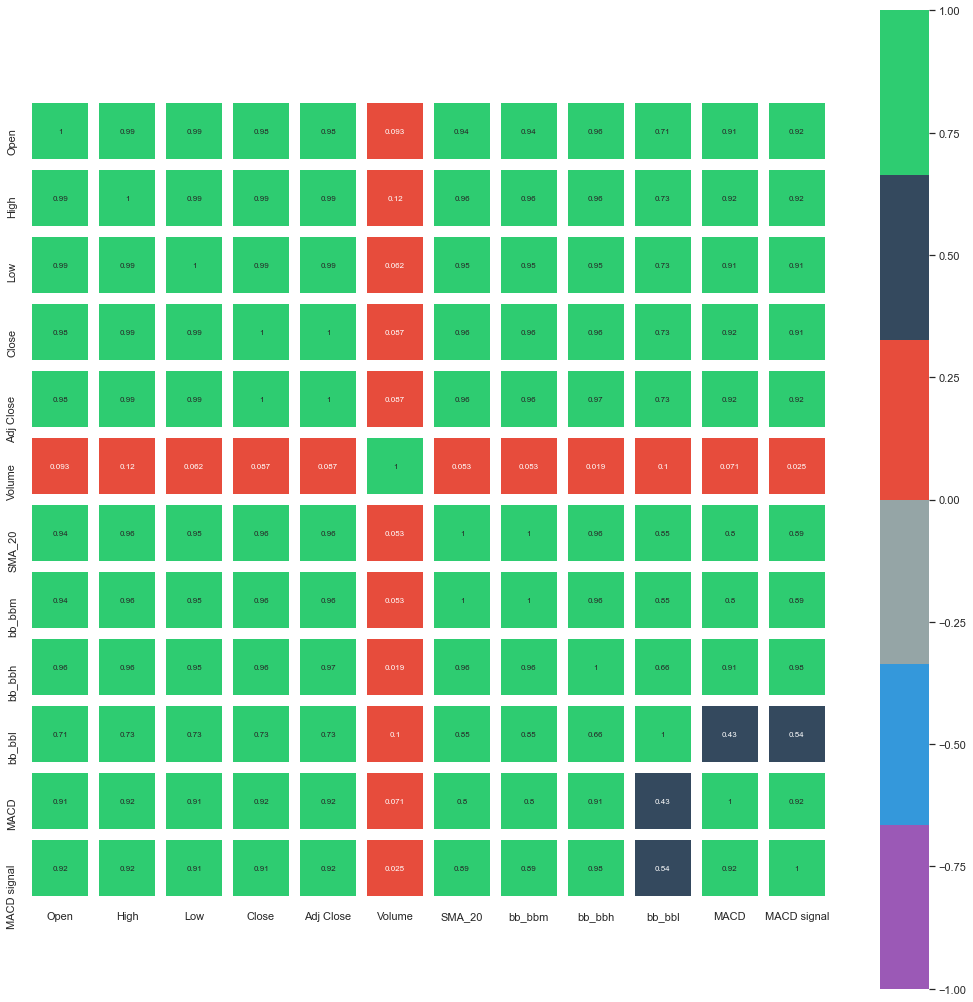

In [4]:
corr_plot(MSFT)

# Feature Wrangling and Setup

##  Predictions

### MSFT Predictions

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 100 and gamma 0.009 values
Predicted Values: [150.07702751 150.07702751 150.07702751 150.07702751 150.07702751]
----------------------------------------------------------------------------------------------------
Actual Values: [157.380005 158.669998 158.960007 157.589996 157.699997]
----------------------------------------------------------------------------------------------------
Model Score: 0.9993038795850729
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 64.12686115558738
----------------------------------------------------------------------------------------------------
RMSE: 8.007924896974707


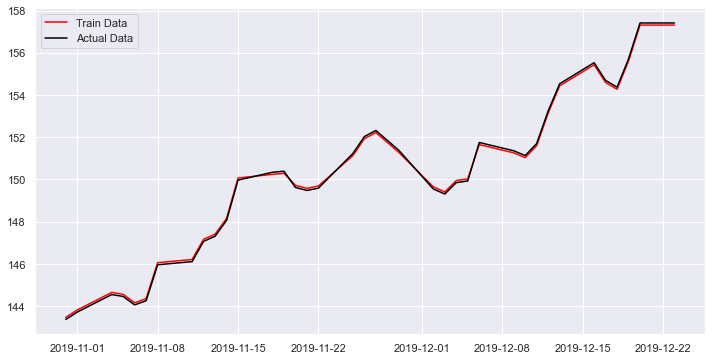

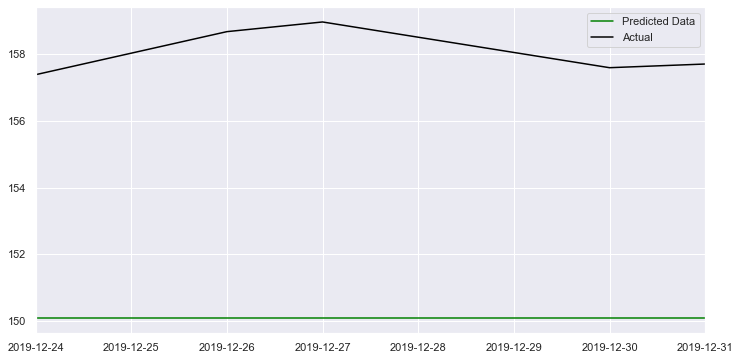

In [5]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 100, G_user=.009, model = 'rbf')

### AAPL Precitions

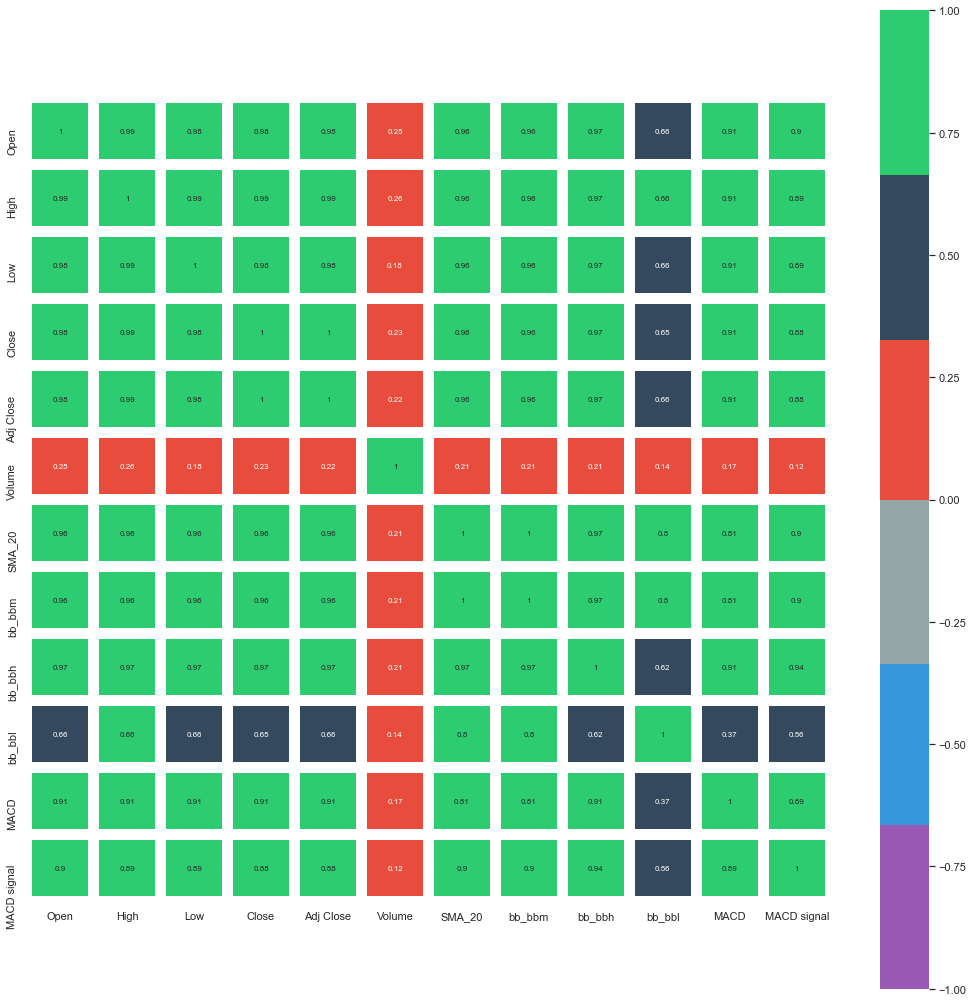

In [6]:
corr_plot(AAPL)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using Grid Search Values C 10 and gamma 1e-05 values
Predicted Values: [265.85413921 265.85413921 265.85413921 265.85413921 265.85413921]
----------------------------------------------------------------------------------------------------
Actual Values: [284.269989 289.910004 289.799988 291.519989 293.649994]
----------------------------------------------------------------------------------------------------
Model Score: 0.9140000977308315
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 584.5154436499648
----------------------------------------------------------------------------------------------------
RMSE: 24.176754200056816


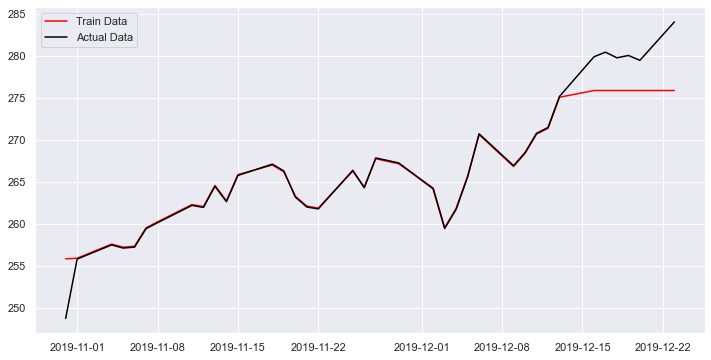

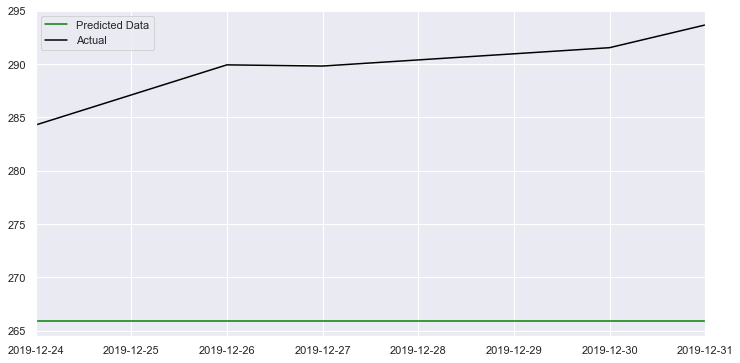

In [7]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='rbf')

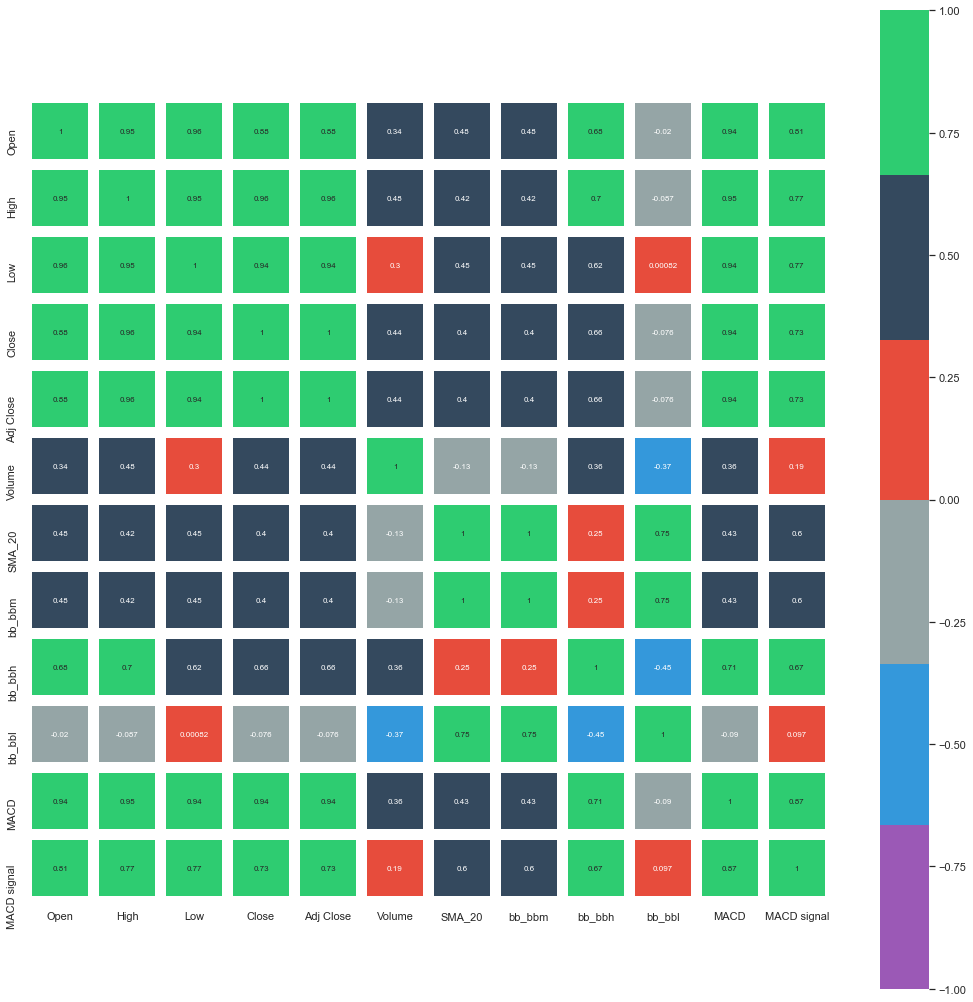

In [8]:
corr_plot(AMZN)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 100 and gamma 0.009 values
Predicted Values: [1771.38269303 1771.38269303 1771.38269303 1771.38269303 1771.38269303]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Model Score: 0.9999792426336678
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 6207.029831404974
----------------------------------------------------------------------------------------------------
RMSE: 78.78470556780024


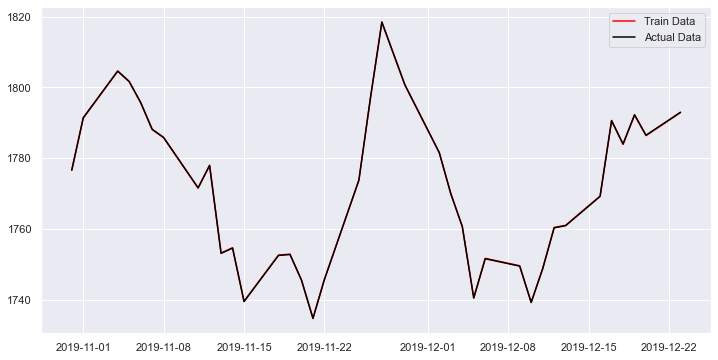

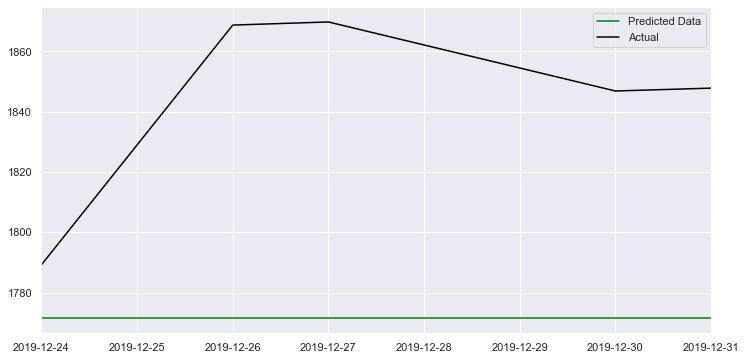

In [9]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=100, G_user=.009)

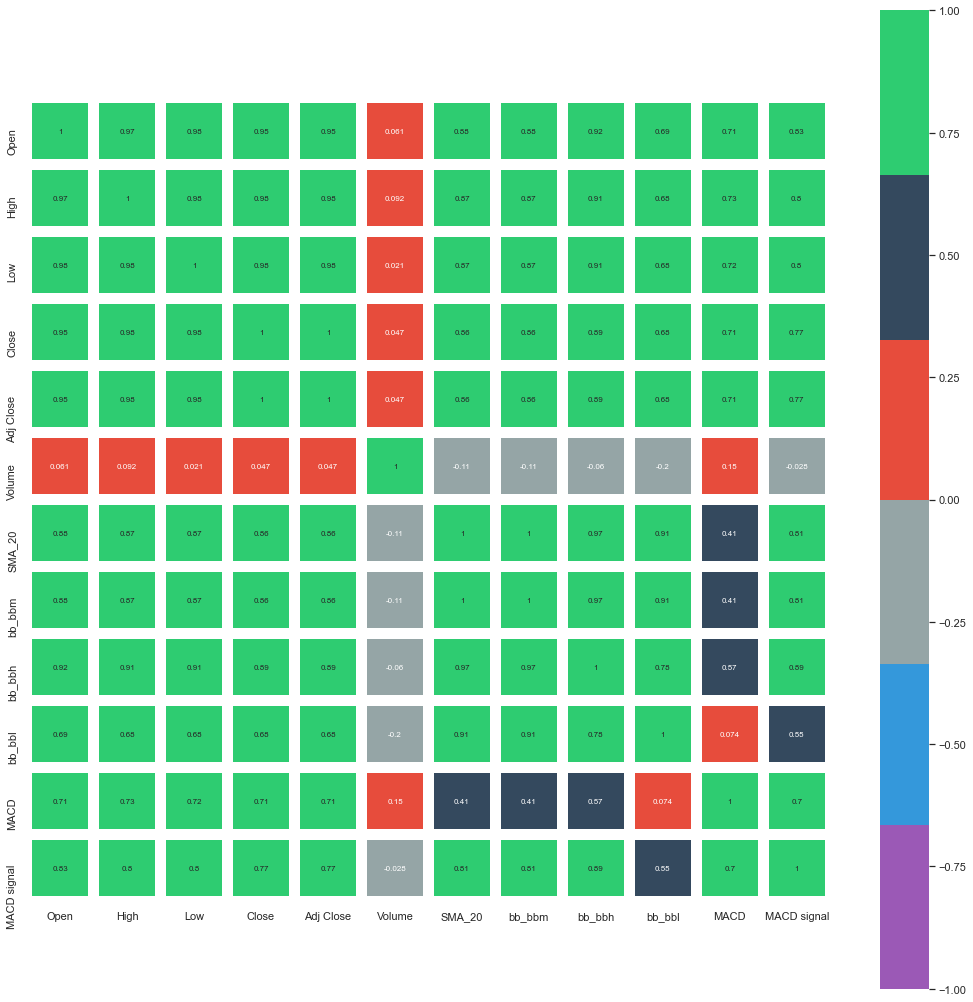

In [10]:

corr_plot(GOOG)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 120 and gamma 0.001 values
Predicted Values: [1318.25407582 1318.25407582 1318.25407582 1318.25407582 1318.25407582]
----------------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
----------------------------------------------------------------------------------------------------
Model Score: 0.9999846613179266
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 844.0235236104243
----------------------------------------------------------------------------------------------------
RMSE: 29.0520829478787


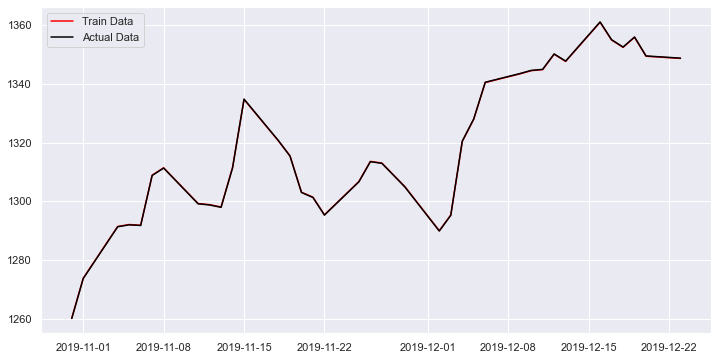

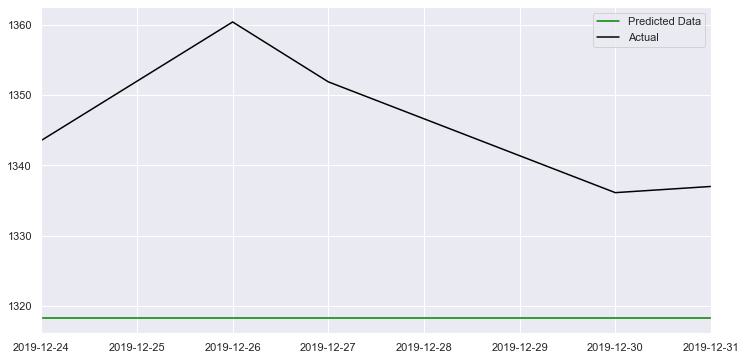

In [11]:
predict_multiple_variables(GOOG, GOOG_dates, num_forecast_days=5, C_user=120, G_user=.001,model =  'rbf')

# Classification Models

## Defining a Classification Problem

The following section explores some ideas of turning stock price predictions into a classification ML problem. Namely, we will explore two questions:

1) Can we tell if a stock will go up or down tomorrow? (It turns out, this is quite difficult)

2) Can we tell if a stock is "trending up" or "trending down"? (This shows a bit of optimism.

Our approach is as follows:

1a) If _perfectly_ executed (that is, if we had actual future data), how much money would this strategy make compared to just buying and holding a stock? We do some backtesting to get a benchmark for the efficacy of the approach.

1b) How realistic is it to predict such movement? We discover that a less-lucrative approach (when executed "perfectly") might be better in practice due to our ability to actually predict it.

2) Using 69 well established technical indicators for trend, momentum, volatility, and volume, can we predict the movement of a stock? How correlated are these indicators? How useful are all of these features in our prediction? We do a correlation analysis and a Random Forest model to assess.

3) Could we do better (albeit, less clearly) by creating the same number of features as selected in step 2 as "fake features" by doing a PCA on the original 69 indicators? Can we improve the accuracy of our top features by adding an element of non-linearity using the Kernel trick?

4) How can we account for the timeseries nature of stocks? We explore adding lag variables to our feature matrix. We also explored "slopes" using linear regression but they were not particularly helpful and have been dropped from the final presentation.

5) Finally, we take a look at a non-linear approach -- the Multi-Layer Perceptron. With the inclusion of the lag variables and two hidden layers, we achieve promising results (>90%) for predicting our chosen indicator. This leaves us with a sense of optimism and motivation for further exploration. We would next investigate engineering more time-related features, as well as using a Recurrent Neural Networks which is well suited for time series data.

### Support Classes
We utilize the following classes in these sections to help back test, create labels, and engineer features:

In [12]:
import ta


class StockTechnicals:
    """
    A class for creating technical indicators of stocks as features and labels from various strategies for training
    Machine Learning models
    :param data: A pandas dataframe of a daily stock ticker data
    Usage:
    a = StockTechnicals(data)
    X = a.features
    y = a.price_will_rise()
    """

    def __init__(self, data):
        self.data = data
        self._features = ta.add_all_ta_features(
            self.data,
            open="Open",
            high="High",
            low="Low",
            close="Close",
            volume="Volume"
        )

    @property
    def features(self):
        return self._features.drop(
            columns=[
                "Date",
                "Open",
                "High",
                "Low",
                "Close",
                "Adj Close",
                "Volume",
                'trend_psar_up',
                'trend_psar_down',
                'trend_psar']
        ).dropna()

    # Can add more derived metrics here
    # e.g. slopes, cross-overs
    def add_slopes(self, metrics=(), days=()):
        if not metrics:
            metrics = list(self.features)
        for m in metrics:
            for d in days:
                self._features[f"{m}_{d}_day_slope"] = self._features.apply(self._add_slope, metric=m, days=d, axis=1)

    def _add_slope(self, row, metric, days=3):
        if row.name < days + 1:
            return None
        x = np.arange(days)
        A = np.vstack([x, np.ones(len(x))]).T
        y = self._features.loc[row.name - days:row.name - 1, metric].values
        slope, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        return slope

    def add_lags(self, metrics=(), days=()):
        if not metrics:
            metrics = list(self.features)
        for m in metrics:
            for d in days:
                self._features[f"{m}_{d}_day_lag"] = self._features.apply(self._add_lag, metric=m, days=d, axis=1)

    def _add_lag(self, row, metric, days=3):
        if row.name < days + 1:
            return None
        return self._features.loc[row.name - days, metric]

    # Possible Strategy labels

    def price_will_rise(self, days=1):
        return np.array(self.features.apply(self._price_will_rise, days=days, axis=1))

    def _price_will_rise(self, row, days=1):
        try:
            if self.data.loc[row.name + days, 'Adj Close'] > self.data.loc[row.name, 'Adj Close']:
                return 1
            return 0
        except KeyError:
            return None

    def future_sma_higher_than_current_price(self, days=7):
        # This metric is the most promising as far as an investment strategy
        return np.array(self.features.apply(self._future_sma_v_price, days=days, axis=1))

    def _future_sma_v_price(self, row, days=7):
        try:
            future_sma = np.mean([self.data.loc[row.name + day + 1, 'Adj Close'] for day in range(days)])
        except KeyError:
            return None

        try:
            if future_sma > self.data.loc[row.name, 'Adj Close']:
                return 1
            return 0
        except KeyError:
            return None

In [13]:
from pyalgotrade import strategy


class TradeHoldStrategy(strategy.BacktestingStrategy):
    """
    A class to test strategies based on a feed of signals (1's and 0's)
    The strategy buys on next 1 and holds until next 0, when it sells and repeats.
    :param future_signals: numpy array of signals of the same length as the feed on which to trade
    """

    def __init__(self, feed, instrument, future_signals, verbose=False):
        strategy.BacktestingStrategy.__init__(self, feed)
        self.instrument = instrument
        self.future_signals = future_signals
        self.adj_close = feed[instrument].getAdjCloseDataSeries()
        self.day = 0
        self.position = None
        self.verbose = verbose

    def onBars(self, bars):
        try:
            todays_signal = self.future_signals[self.day]
            if self.day == 0:
                yesterdays_signal = 0
            else:
                yesterdays_signal = self.future_signals[self.day - 1]

            if todays_signal > yesterdays_signal:
                self.position = self.enterLong(self.instrument, 100)
            elif todays_signal < yesterdays_signal:
                self.position.exitMarket()
        except IndexError:
            pass
        self.day += 1

    def onEnterOk(self, position):
        if self.verbose:
            exec_info = position.getEntryOrder().getExecutionInfo()
            self.info("BUY at $%.2f" % (exec_info.getPrice()))

    def onExitOk(self, position):
        if self.verbose:
            exec_info = position.getExitOrder().getExecutionInfo()
            self.info("SELL at $%.2f" % (exec_info.getPrice()))
        self.position = None

### Picking a Strategy as a Classificaion Problem

In [14]:
# The following code backtests some possible "returns" when implementing a strategy using the 
# actual future data to generate signals. We use the convention TradeHoldStrategy where we are 
# attempting to find a signal (a classification) to tell us to buy, hold or sell.
# It is our goal to find one that proves to make money and that we can somewhat accurately predict.

from copy import deepcopy
import pandas as pd
import numpy as np

#from src.features.build_features import StockTechnicals

#from src.models.backtest_strategy import TradeHoldStrategy

In [19]:
# load data using MSFT 
ticker = "MSFT"
all_daily_data = pd.read_csv(f'./.data/{ticker}.csv')

In [20]:
# create a feature matrix and some labels using our handy StockTechnicals class
# we will actually only need labels for this decision, as we're using observed data
technicals = StockTechnicals(all_daily_data)
X = technicals.features
y = technicals.price_will_rise()

In [21]:
### BACKTESTING ###
# import a backtesting library
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.stratanalyzer import returns, trades

In [22]:
# build our backtesing feed using MSFT daily data
base_feed = yahoofeed.Feed()
base_feed.addBarsFromCSV(f"{ticker}", f'./.data/{ticker}.csv')

In [23]:
# As a benchmark, we will buy 100 shares of MSFT on day one and hold. 

# buy one share on day one and hold as a benchmark
benchmark_feed = deepcopy(base_feed)
benchmark_trades = np.ones(len(all_daily_data))
benchmark_strat = TradeHoldStrategy(benchmark_feed, f'{ticker}', benchmark_trades)

# performance metrics for strategy evaluation
ret_analyzer = returns.Returns()
benchmark_strat.attachAnalyzer(ret_analyzer)
tradesAnalyzer = trades.Trades()
benchmark_strat.attachAnalyzer(tradesAnalyzer)

In [24]:
# backtest the strategy 
benchmark_strat.run()
bmk_value = round(benchmark_strat.getResult() - 1000000, 2)
print(f"Final portfolio increase: ${bmk_value}")
print(f"Total trades: {tradesAnalyzer.getCount()}")

Final portfolio increase: $13318.0
Total trades: 0


In [25]:
# Now let's backtest a strategy with the training labels we created in StockTechnicals. The 
# strategy is to BUY 100 shares if we predict the price will rise the following day and HOLD 
# until we predict the market will go down the following day, when we SELL 100 shares and 
# wait until we predict another rise.
# Note that there is some loss as we can't trade after-hours in our sim and open prices do not 
# always match closing prices, but it is still very good (results below)

perf_feed = deepcopy(base_feed)
perf_trades = np.concatenate([np.zeros(len(all_daily_data) - len(y)), y])
perf_strat = TradeHoldStrategy(perf_feed, f'{ticker}', perf_trades)

# performance metrics
ret_analyzer = returns.Returns()
perf_strat.attachAnalyzer(ret_analyzer)
tradesAnalyzer = trades.Trades()
perf_strat.attachAnalyzer(tradesAnalyzer)

In [26]:
# backtest the strategy
perf_strat.run()
perf_strat_value = round(perf_strat.getResult() - 1000000, 2)
print(f"Final portfolio increase: ${perf_strat_value}")
perf_pct_improve = round((perf_strat_value / bmk_value - 1) * 100, 1)
print(f"Percentage gain v. buy-and-hold bmk: {perf_pct_improve}%")
print("Total trades: %d" % (tradesAnalyzer.getCount()))

Final portfolio increase: $65485.0
Percentage gain v. buy-and-hold bmk: 391.7%
Total trades: 770


In [27]:
# As we can see, perfect execution of this strategy would improve our returns by over 400%
# However daily stock movement is notoriously difficult to predict, so we'll explore another
# strategy as well.

# Backtest another strategy. This strategy is to to BUY 100 shares if we predict the N-day SMA 
# will be higher than the current stock price in N days, and HOLD until we predict the N-day SMA 
# will be lower than the current stock price in N days, when we SELL 100 shares and wait until 
# we predict another rise.
N = 26

# generate our labels using our StockTechnicals class
y_sma = technicals.future_sma_higher_than_current_price(days=N)

sma_feed = deepcopy(base_feed)
sma_trades = np.concatenate([np.zeros(len(all_daily_data) - len(y_sma)), y_sma])
sma_strat = TradeHoldStrategy(sma_feed, f'{ticker}', sma_trades)

# performance metrics
ret_analyzer = returns.Returns()
sma_strat.attachAnalyzer(ret_analyzer)
tradesAnalyzer = trades.Trades()
sma_strat.attachAnalyzer(tradesAnalyzer)

In [28]:
# run the N-day sma strategy
sma_strat.run()
sma_value = round(sma_strat.getResult() - 1000000, 2)
print(f"Final portfolio increase: ${sma_value}")
sma_pct_improve = round((sma_value / bmk_value - 1) * 100, 1)
print(f"Percentage gain v. buy-and-hold bmk: {sma_pct_improve}%")
print("Total trades: %d" % (tradesAnalyzer.getCount()))

Final portfolio increase: $34817.0
Percentage gain v. buy-and-hold bmk: 161.4%
Total trades: 147


In [29]:
# As we can see with this strategy, the potential returns are not as high, but 
# it's more conservative and likely a bit easier to predict as it's using a more general metrics
# in the moving average rather than daily close data. We will demonstrate this next.

In [30]:
### EYEBALLING FOR FEASIBILITY ###
# Using a naive, unoptimized Logistic Regression model, we will evaluate benchmark peformances for 
# each of the two strategies outlined above.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [31]:
# TEST NEXT DAY STRATEGY IN LOGISTIC REGRESSION

# set up X_daily and y_daily (y has trailing nan values, so we truncate here) 
y_daily = y[~np.isnan(y)]
X_daily = X[:len(y_daily)]

# preprocess the data
X_train, X_test, y_train, y_test = train_test_split(X_daily, y_daily, random_state=2, stratify=y_daily)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# run a logistic regression
for c in [0.01, 0.1, 1.0, 10, 100]:
    lr = LogisticRegression(C=c, random_state=2, solver='liblinear')
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.5148648648648648
Accuracy score: 0.5067567567567568
Accuracy score: 0.5081081081081081
Accuracy score: 0.5054054054054054
Accuracy score: 0.4945945945945946


In [32]:
# As we can see above, a naive LogisticRegression doesn't do any better than simply guessing
# whether the stock will rise the following day

In [33]:
# TEST N-DAY SMA STRATEGY IN LOGISTIC REGRESSION

y_sma = y_sma[~np.isnan(y_sma)]
X_sma = X[:len(y_sma)]

# preprocess the data
X_train, X_test, y_train, y_test = train_test_split(X_sma, y_sma, random_state=2, stratify=y_sma)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# run a logistic regression
for c in [0.01, 0.1, 1.0, 10, 100]:
    lr = LogisticRegression(C=c, random_state=2, solver='liblinear')
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.6439290586630286
Accuracy score: 0.6739427012278308
Accuracy score: 0.679399727148704
Accuracy score: 0.6807639836289222
Accuracy score: 0.6725784447476125


In [34]:
# Compared to predicting the one-day return, predicting the 26-day sma rise is much more
# promising. Our _very_ naive Logistic Regression classifer scores at almost 64%. For this
# reason, we will move forward attempting to predict these labels.

### Feature Selection using Correlations and Random Forests

In [35]:
from copy import deepcopy
import pandas as pd
import numpy as np

#from src.features.build_features import StockTechnicals

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [36]:
# load data using MSFT 
ticker = "MSFT"
all_daily_data = pd.read_csv(f'./.data/{ticker}.csv')

In [40]:
# set up our X and y

N = 26

# create a feature matrix and some labels using our handy StockTechnicals class
technicals = StockTechnicals(all_daily_data)
X = technicals.features
y = technicals.future_sma_higher_than_current_price(N)

# we don't have the last N days of data
y = y[~np.isnan(y)]
X = X[:len(y)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)


/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/ta/trend.py:567: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/ta/trend.py:571: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [41]:
# take a look at the relative importances of all features using a random forest 
feat_labels = list(X.columns)
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f"{f + 1:2}) {X.columns[indices[f]]:<28} {round(importances[indices[f]], 4):>}")

 1) trend_visual_ichimoku_b      0.048
 2) volume_obv                   0.038
 3) volume_nvi                   0.0322
 4) trend_visual_ichimoku_a      0.0271
 5) trend_ichimoku_b             0.0248
 6) volume_adi                   0.0232
 7) trend_kst_diff               0.0229
 8) trend_mass_index             0.0224
 9) others_cr                    0.022
10) trend_ema_slow               0.0205
11) trend_adx                    0.0203
12) volatility_bbh               0.0202
13) volatility_kcw               0.0196
14) volatility_bbl               0.0193
15) trend_sma_slow               0.019
16) trend_kst_sig                0.0188
17) volatility_atr               0.0188
18) momentum_kama                0.0186
19) trend_ema_fast               0.0184
20) trend_macd_diff              0.018
21) volatility_bbw               0.018
22) volume_cmf                   0.0178
23) volatility_dcl               0.0175
24) volume_vwap                  0.0171
25) trend_trix                   0.0169
26) tr

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns

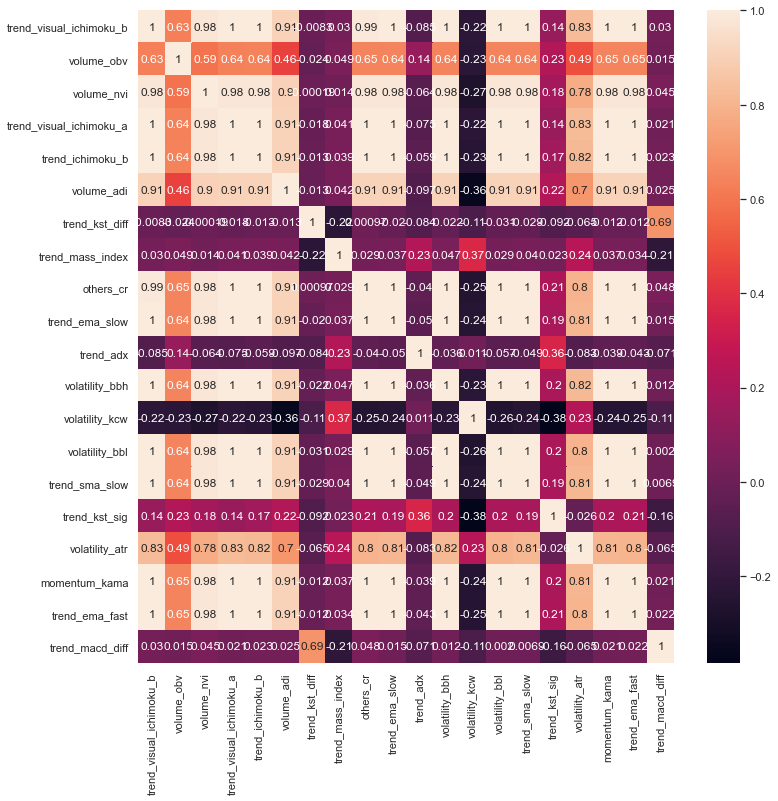

In [43]:
# check the top 20 features to see if any are correlated
top_feats_X = X_train.iloc[:,indices[:20]]
corr = top_feats_X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot = True, label = ticker)

In [44]:
# there are lots of correlated features, so let's remove them in order of priority
ind_feats = []
for i in indices:
    # iterating in importance order, don't include a feature if it has a correlation
    # stronger than 0.9 (or -0.9) with a features already included
    if all(abs(X_train.corr().iloc[ind_feats, i]) < 0.9):
        ind_feats.append(i)

print(f'We are left with {len(ind_feats)} "independent" (non-correlated) features')

We are left with 42 "independent" (non-correlated) features


In [45]:
# observe feature importances of this subset using a new random forest
ind_feats_X = X_train.iloc[:, ind_feats]

ind_feats_forest = RandomForestClassifier(n_estimators=500, random_state=1)
ind_feats_forest.fit(ind_feats_X, y_train)
ind_importances = ind_feats_forest.feature_importances_

for rk, (idx, imp) in enumerate(sorted(zip(ind_feats, ind_importances), key=lambda x: x[1], reverse=True)):
    print(f"{rk + 1:2}) {X.columns[idx]:<28} {round(imp, 4):>}")

 1) trend_visual_ichimoku_b      0.0936
 2) volume_obv                   0.0537
 3) volatility_kcw               0.0419
 4) trend_kst_sig                0.0409
 5) volatility_atr               0.0407
 6) trend_mass_index             0.0398
 7) volatility_bbw               0.037
 8) volume_cmf                   0.0364
 9) trend_macd_signal            0.0357
10) trend_kst_diff               0.0356
11) trend_adx                    0.0343
12) trend_macd_diff              0.0315
13) momentum_tsi                 0.03
14) trend_adx_pos                0.0271
15) volume_sma_em                0.0266
16) momentum_ao                  0.0262
17) volume_vpt                   0.0249
18) volume_fi                    0.0248
19) momentum_roc                 0.0239
20) trend_adx_neg                0.0239
21) momentum_mfi                 0.0218
22) momentum_rsi                 0.0218
23) momentum_uo                  0.0214
24) trend_vortex_ind_neg         0.0206
25) trend_aroon_ind              0.0202
26)

In [46]:
# Setting a threshold of 0.3 leaves us with 13 indicators as featres, which 
# sounds like a good place to start

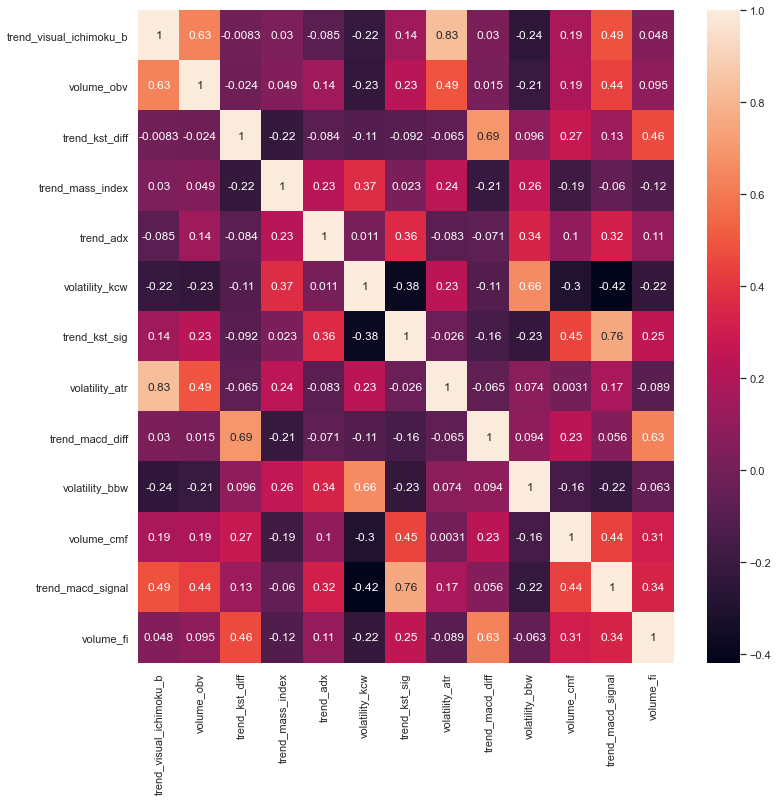

In [47]:
# Take a look again at the correlation matrix of our top 13 features to make sure nothing changed
top_feats_X = X_train.iloc[:,ind_feats[:13]]
corr = top_feats_X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot = True, label = ticker)


### Exploring PCA and KPCA approaches

In [48]:
import numpy as np
import pandas as pd

from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

#from src.features.build_features import StockTechnicals

In [49]:
# Load training data using MSFT
train_ticker = "MSFT"
all_msft_data = pd.read_csv(f'./.data/{train_ticker}.csv')

# number of future days for SMA to rise
N = 26

In [50]:
technicals = StockTechnicals(all_msft_data)
X = technicals.features
y = technicals.future_sma_higher_than_current_price(N)

# we don't have the last N days of data (they're in the future)
y = y[~np.isnan(y)]
X = X[:len(y)]

/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/ta/trend.py:567: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/ta/trend.py:571: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [51]:
# limit to top features as determined by a RandomForest in feature-selection.ipnyb
top_features = [
    'trend_visual_ichimoku_b',
    'volume_obv',
    'volatility_kcw',
    'volatility_atr',
    'trend_mass_index',
    'trend_kst_sig',
    'volume_cmf',
    'trend_adx',
    'trend_macd_signal',
    'volatility_bbw',
    'trend_kst_diff',
    'momentum_tsi',
    'trend_macd_diff',
]

In [52]:
# limit X to top features only
X_top = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, random_state=2, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [53]:
# run a logistic regression to get a benchmark performance on the top 13 features
for c in [0.01, 0.1, 1.0, 10, 100]:
    lr = LogisticRegression(C=c, random_state=2, solver='liblinear')
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n"
          f"F1-Score:       {f1_score(y_test, y_pred)}")
    

Accuracy score: 0.6412005457025921
F1-Score:       0.7641255605381166
Accuracy score: 0.6398362892223738
F1-Score:       0.7551020408163265
Accuracy score: 0.635743519781719
F1-Score:       0.7478753541076487
Accuracy score: 0.6412005457025921
F1-Score:       0.7507109004739336
Accuracy score: 0.6412005457025921
F1-Score:       0.7507109004739336


In [54]:
# Limiting to the top 13 features achieves an accuracy very close to using all 69 (~65% v ~69%).
# As an alternative, let's see what happens when reducing to 13 "fake" features using PCA 

In [55]:
# set up test and train datasets using full X
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# fit a pca with 13 "fake" attributes
pca = PCA(13, random_state=1, tol=0.1)
X_train_std_pca = pca.fit_transform(X_train_std)
X_test_std_pca = pca.transform(X_test_std)

In [56]:
# run a logistic regression with the 13-feature pca dataset
for c in [0.01, 0.1, 1.0, 10, 100]:
    lr = LogisticRegression(C=c, random_state=2, solver='liblinear')
    lr.fit(X_train_std_pca, y_train)
    y_pred = lr.predict(X_test_std_pca)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n"
          f"F1-Score:       {f1_score(y_test, y_pred)}")

Accuracy score: 0.6330150068212824
F1-Score:       0.760035682426405
Accuracy score: 0.6289222373806276
F1-Score:       0.7609841827768014
Accuracy score: 0.6302864938608458
F1-Score:       0.762071992976295
Accuracy score: 0.6302864938608458
F1-Score:       0.762071992976295
Accuracy score: 0.6302864938608458
F1-Score:       0.762071992976295


In [57]:
# Using a PCA with 13 "fake" attributes doesn't achieve better results than simply using
# our 13 top attributes as selected from the RandomForest. Therefore, we'll stick with those
# as they're more easily explained. Next we'll try using the kernel trick to see if we can
# improve classification by temporarily projecting data into a higher dimensional space

In [58]:
# trying out kpca

for k in ('poly', 'rbf', 'sigmoid', 'cosine', 'precomputed'):
    print(f"\nKernel: {k}")
    kpca = KernelPCA(n_components=13, random_state=1, kernel='poly', gamma=1.0)
    X_train_std_kpca = kpca.fit_transform(X_train_std)
    X_test_std_kpca = kpca.transform(X_test_std)
    
    # run a logistic regression
    for c in [0.01, 0.1, 1.0, 10, 100]:
        lr = LogisticRegression(C=c, random_state=2, solver='liblinear')
        lr.fit(X_train_std_kpca, y_train)
        y_pred = lr.predict(X_test_std_kpca)
    
        print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n"
              f"F1-Score:       {f1_score(y_test, y_pred)}")


Kernel: poly
Accuracy score: 0.6480218281036835
F1-Score:       0.779863481228669
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271

Kernel: rbf
Accuracy score: 0.6480218281036835
F1-Score:       0.779863481228669
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271

Kernel: sigmoid
Accuracy score: 0.6480218281036835
F1-Score:       0.779863481228669
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:       0.7830508474576271
Accuracy score: 0.6507503410641201
F1-Score:     

In [59]:
# It doesn't seem like the kernel trick with KPCA is very effective at improving our accuracy either.
# Above is just a sample of the various hyperparameter combinations we attempted. It is our belief
# that we will need to engineer additional features or implement deeper neural networks to improve 
# our classification accuracy

### Adding Lag Variables

In [60]:
# Stocks are inherently a time-series prediction, so let's see if adding lag values to  various
# metrics helps improve the prediction accuracy using a linear model at all

lag_days = [1, 2, 3, 4, 5, 10, 20]

# add lags is a convenience function I wrote to add trailing values to a list of metrics
all_msft_data = pd.read_csv(f'./.data/{train_ticker}.csv')
technicals = StockTechnicals(all_msft_data)
technicals.add_lags(metrics=top_features, days=lag_days)
X = technicals.features
y = technicals.future_sma_higher_than_current_price(26)

# drop final 26 days which we don't have a y value
y = y[~np.isnan(y)]
X = X[:len(y)]

/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/ta/trend.py:567: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/ta/trend.py:571: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [61]:
# limit to top features as determined by a RandomForest in feature-selection.ipnyb
top_features = [
    'trend_visual_ichimoku_b',
    'volume_obv',
    'volatility_kcw',
    'volatility_atr',
    'trend_mass_index',
    'trend_kst_sig',
    'volume_cmf',
    'trend_adx',
    'trend_macd_signal',
    'volatility_bbw',
    'trend_kst_diff',
    'momentum_tsi',
    'trend_macd_diff',
]

top_features.extend([f"{feat}_{n}_day_lag" for feat in top_features for n in lag_days])
X_top = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, random_state=2, stratify=y)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# run a logistic regression
for c in [0.01, 0.1, 1.0, 10, 100]:
    lr = LogisticRegression(C=c, random_state=2, solver='liblinear')
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.652530779753762
Accuracy score: 0.6621067031463749
Accuracy score: 0.6593707250341997
Accuracy score: 0.6511627906976745
Accuracy score: 0.6443228454172366


In [62]:
# Even with lag variables it seems the data just aren't linearly separable.
# Let's try a non-linear classifier like a multi-layer perceptron


### Training a Multi-Layer Perceptron

In [63]:
from sklearn.neural_network import MLPClassifier

for a in [0.001, 0.01, 0.1]:
    mlp = MLPClassifier(
        hidden_layer_sizes=(39, 39), 
        solver='lbfgs', 
        max_iter=5000, 
        random_state=2, 
        alpha=a, 
        activation='relu')
    mlp.fit(X_train_std, y_train)
    y_pred = mlp.predict(X_test_std)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.93296853625171
Accuracy score: 0.9179206566347469
Accuracy score: 0.9165526675786594


In [64]:
# There are some early signs of optimism using the MLP classifier with
# predictions as high as 93.6% accuracy with an alpha of 0.01. 39 units
# two hidden layers was selected somewhat arbitrarily as 3x13 (# of impt features)
# Other combinations - larger and smaller - were only nominally different and
# often worse, so this is merely to demonstrate a more "successful" case. 
# Let's try some other hyperparameter combinations for fun.

In [65]:
for solver in ['adam', 'sgd']:
    for activation in ['relu', 'tanh', 'logistic']:
        mlp = MLPClassifier(
            hidden_layer_sizes=(39, 39), 
            solver=solver,  
            max_iter=1000, 
            random_state=2, 
            alpha=0.01, 
            activation=activation,
            learning_rate='adaptive')
        mlp.fit(X_train_std, y_train)
        y_pred = mlp.predict(X_test_std)

        print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
        

Accuracy score: 0.920656634746922
Accuracy score: 0.9124487004103967
Accuracy score: 0.9247606019151847


/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy score: 0.908344733242134


/c/g/njit/njit-ml-project-spring-2020/.venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy score: 0.905608755129959
Accuracy score: 0.6374829001367989


In [66]:
# Nothing in the above supercedes our initial MLP (this was an intentional demonstration)
# Perhaps there's a chance we can predict the general "trend" of a stock somewhat accurately 
# with an MLP classifier on a handful of technical indicators along with some lag values.
# Future analysis will be performed on engineering new features as well as recurrent nueral
# network implementations, which are particularly well suited for timeseries data.





# Regression Models

> first some imports

In [67]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error 
from ta import add_all_ta_features

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
#from src.visualization.visualize import DisplayTicker
#from src.features.build_features import StockTechnicals
#from src.models.backtest_strategy import TradeHoldStrategy




## Convert Data Function

The function below will load a CSV file with a start and end date to filter out the time range for testing. 

In addition, for feature selection, I used the following subset features for regression, there were over 85s features in the TA library:

data_df['SMA_20'] = indicator_SMA20.sma_indicator()

data_df['bb_bbm'] = indicator_bb.bollinger_mavg()

data_df['bb_bbh'] = indicator_bb.bollinger_hband()

data_df['bb_bbl'] = indicator_bb.bollinger_lband()

data_df['MACD'] = indicator_MACD.macd()

data_df['MACD signal'] = indicator_MACD.macd_signal()


In [68]:
def convert_data(stock_ticker_csv, start_date, end_date):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    """

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
 

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)

    indicator_bb = ta.volatility.BollingerBands(close=data_df["Close"], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df["Close"],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df["Close"],n_fast=5, n_slow=30, fillna=True)
  
    # Features added to original date
    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()
 
    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates




In [69]:
# This function was used to do a GridSearch for SVR. I was originally using it to calculate the best parameters if no specific features were provided.

def svc_param_selection(X, y, nfolds, model):
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel=model), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_

## Model Training and Prediction Function

This function takes the ticker dataframe, forecasted number of dates (5 in this case), and tries to predict a price based on the probided parameters. If no parameters are provided, it will leverage the Grid search parameters.

In [70]:
def predict_multiple_variables(ticker_df, dates_org, num_forecast_days, C_user=None, G_user=None, model =  'rbf'):

    #features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    features=['Date','SMA_20','Open', 'bb_bbl']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)
    #print(f'{type(dates_org[-num_forecast_days:])}')
    #print(f'{type(dates_org[-num_forecast_days:].values)}')
    
    #print(dates_org[-num_forecast_days:])
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Adj Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Adj Close']]
    
    #  Grid Search gets extremely slow for any models beyond rbf
    best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)
    
    if C_user is None or G_user is None:
        C_user = best_params["C"]
        G_user = best_params["gamma"]
        #C_user = 1000
        #G_user = 0.008
        print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
        #print(f'Using Default values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')
    
    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    
    svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    
    
    y_pred = svr_rbf.predict(test_x)
    print("=" * 90)
    print("Predicted Values: {}".format(y_pred))
    print("-" * 90)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 90)
    print(f"Model Score: {svr_rbf.score(train_x, train_y)}")
    print("-" * 90)
    print(f"Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 90)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 90)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 90)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    #TODO
    #plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

    



In [71]:
def predict_using_random_forest(ticker_df, dates_org, num_forecast_days, estimators_user=1000, criterion_user='mse', state = 1, n_jobs= -1, max_depth=3):

    #features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    features=['Date','SMA_20','Open', 'bb_bbl']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)

    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Adj Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Adj Close']]    

    # Fit training data using SVR/RBF
    #svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    rand_forest = RandomForestRegressor(n_estimators=estimators_user, criterion=criterion_user, random_state=state, n_jobs=n_jobs, max_depth=max_depth)
    #svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    rand_forest.fit(train_x, train_y.values.reshape(-1,))
    y_train_pred = rand_forest.predict(train_x)

    y_pred = rand_forest.predict(test_x)
    print("=" * 90)
    print("Test Data Predicted Values: {}".format(y_pred))
    print("-" * 90)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 90)
    print(f"Train Model Score: {rand_forest.score(train_x, y_train_pred)}")
    print("-" * 90)
    print(f"Test Model Score: {rand_forest.score(test_x, y_pred)}")
    print("-" * 90)
    print(f"Train Model R2 Score: {r2_score(train_y, y_train_pred)}")
    print("-" * 90)
    print(f"Test Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 90)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 90)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 90)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        y_train_pred, 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], rand_forest.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], rand_forest.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

In [72]:
def corr_plotOld(df):
    corrMatrix = df.drop(columns=['index','Date','Pretty Date']).corr()
    print(corrMatrix.shape)
    import seaborn as sn
    sn.heatmap(corrMatrix, 
            annot=True, 
            vmin = -1, 
            vmax=1, 
            center=0,
            fmt='.2g',
            linewidths=10,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 1.0},
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
    plt.figure(figsize = (125,125))
    plt.show()


## Predicting Microsoft Stock Prices

SVR fails to predict prices well with the test data. The prediction numbers are off quite a bit, even with day 1. In looking at the chart below, it is obvious that the model appears to be overfitting and therefore cannot properly deal with unseen data.

### Date Selection

For data selection, I choose to use 2019. as a training year to test how well SVR/Random Forests regressors would perform. This helped test a few scenarios for the data. 

In [73]:
start_date = '2019-01-31'
end_date = '2019-12-31'
MSFT, MSFT_dates = convert_data('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data('./.data/_GSPC.csv',start_date, end_date)

### Correlation Matrix based for Microsoft

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

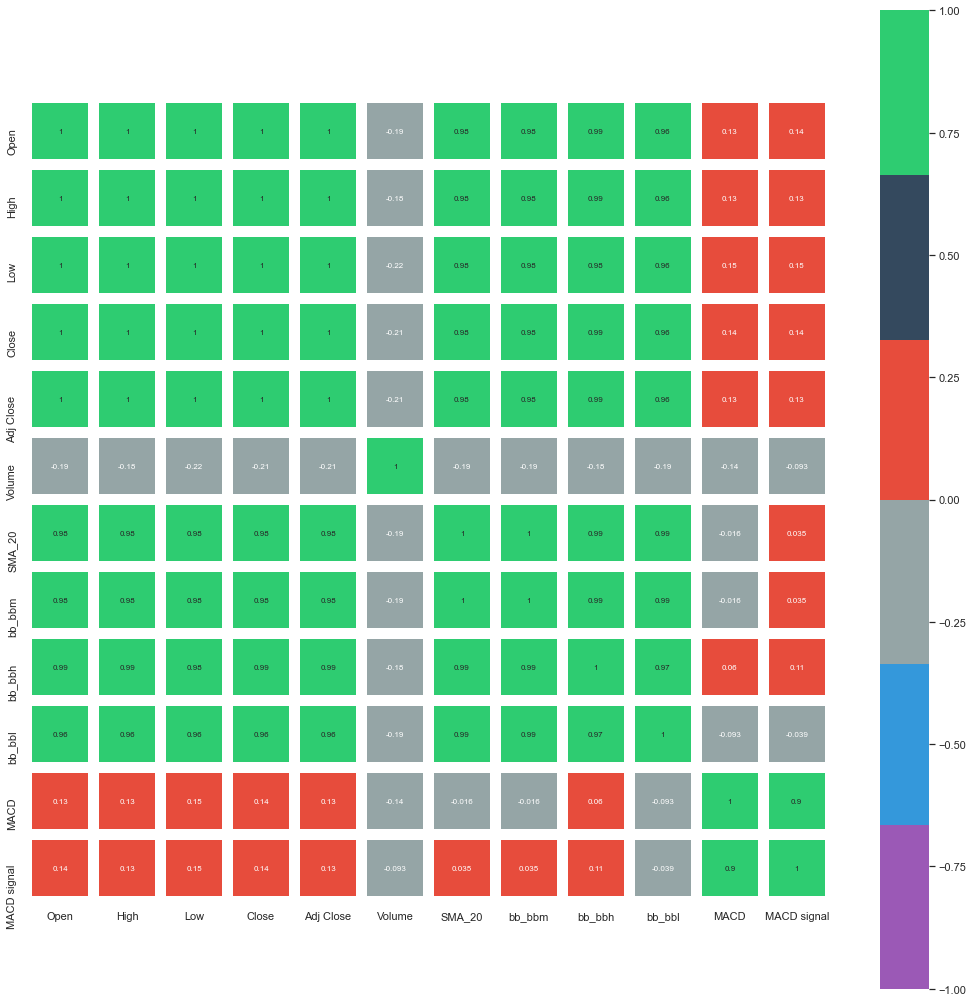

In [74]:
corr_plot(MSFT)

## Using Random Forests for Microsoft Stock

In this test, I used Random Forests to forest prices for Microsoft's stock. It does a pretty good job of staying close to the actual prices compared to SVR.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [156.7099719 156.7099719 155.9261126 156.7099719 156.2941073]
------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
------------------------------------------------------------------------------------------
Train Model Score: 1.0
------------------------------------------------------------------------------------------
Test Model Score: 1.0
------------------------------------------------------------------------------------------
Train Model R2 Score: 0.998228818198949
------------------------------------------------------------------------------------------
Test Model R2 Score: -4.197952611051045
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 2.0627071969722843
-----------------------

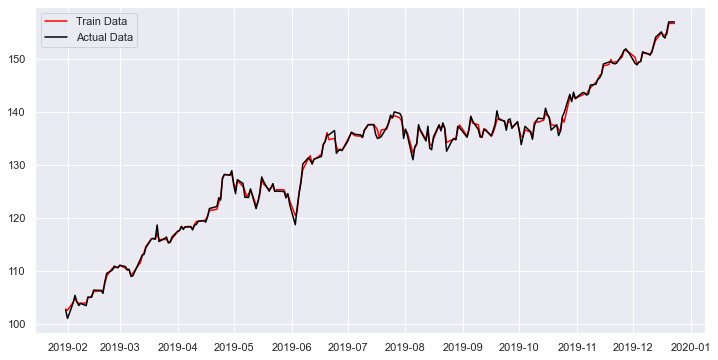

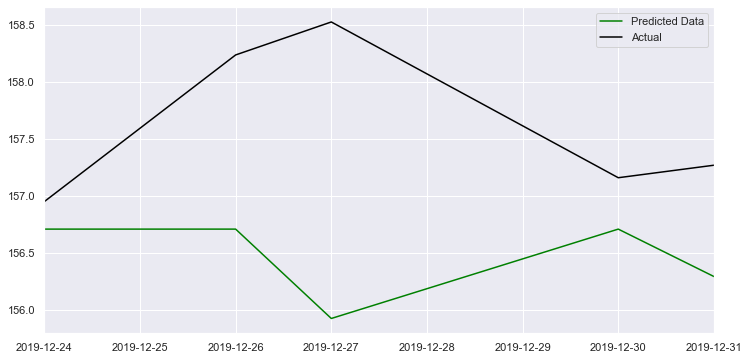

In [75]:
predict_using_random_forest(MSFT, MSFT_dates, num_forecast_days=5, estimators_user=10, max_depth=None)

## Using SVM (Regression) for Microsoft Stock

I next tried to leverage SVR (A component of SVM) to predict Microsoft's stock price. In my tuning, I found that using a C value for 1000 and a Gamma of .009 gave me the most reasonable results, but the predictions were quite off after day 1. Random Forests did a much better job overall. In addition, I was only able to use rbf, as linear and poly would cause my machine to run for an extremely long time. I ultimately had to stop and removing those two models from my testing.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 0.009 values
Predicted Values: [157.63060326 155.53830369 151.40569106 145.51812071 145.70659294]
------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
------------------------------------------------------------------------------------------
Model Score: 0.9981510843807295
------------------------------------------------------------------------------------------
Model R2 Score: -164.1760808755932
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 65.54694055220895
------------------------------------------------------------------------------------------
RMSE: 8.09610650573527


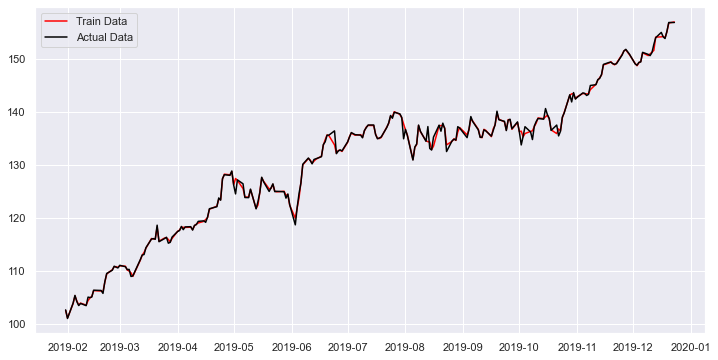

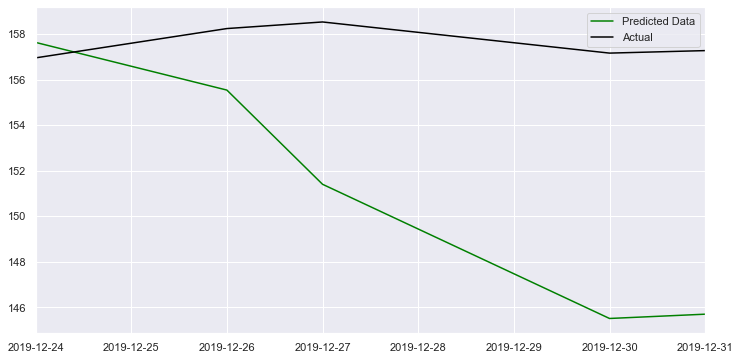

In [76]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 1000, G_user=.009, model = 'rbf')


## Predicting Apple Stock Prices

## Correlation Matrix based for Apple

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

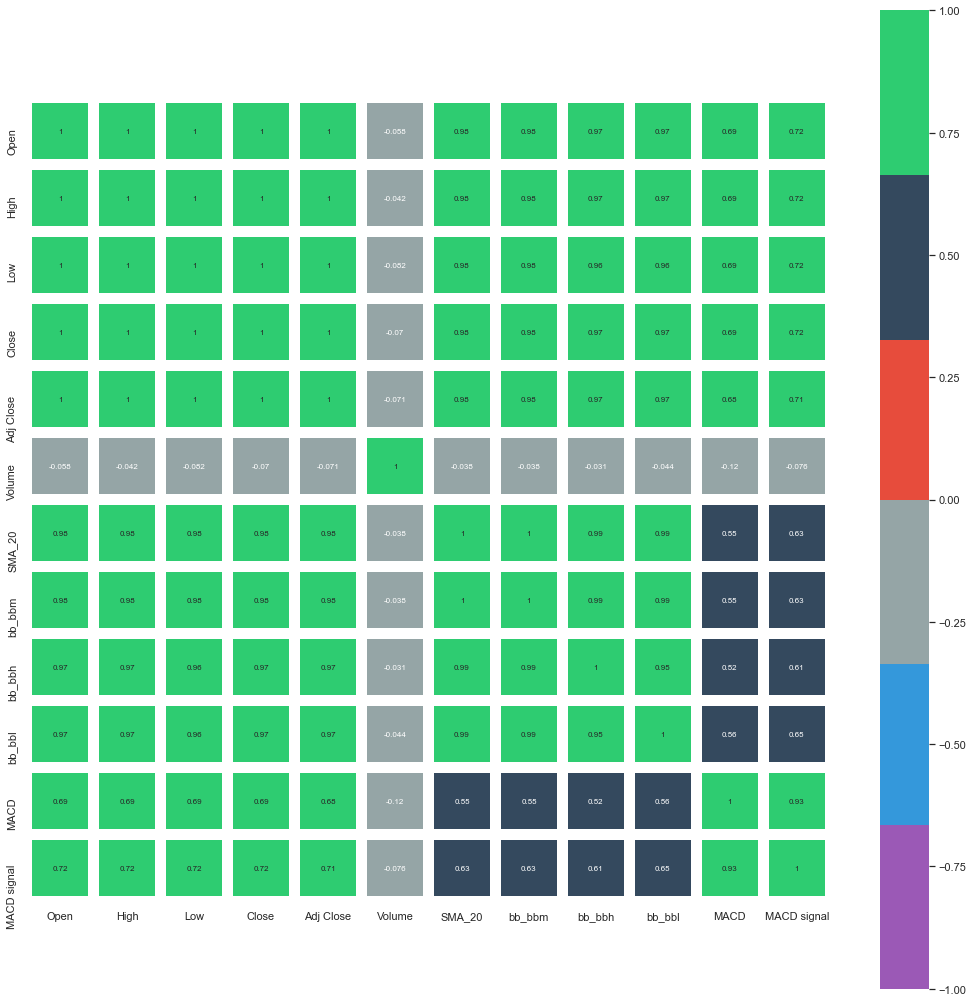

In [77]:
corr_plot(AAPL)

## Using Random Forests for Apple Stock
In this test, I used Random Forests to forest prices for Apple. It did a decent job, but the predictions were relatively static. The model did not seem to handle the flucuations as well.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [281.00201995 281.00749266 280.7921875  280.87138488 280.96500763]
------------------------------------------------------------------------------------------
Actual Values: [282.831299 288.44278  288.333313 290.044617 292.163818]
------------------------------------------------------------------------------------------
Train Model Score: 1.0
------------------------------------------------------------------------------------------
Test Model Score: 1.0
------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9992474258656014
------------------------------------------------------------------------------------------
Test Model R2 Score: -5.788909413059695
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 65.01197494170032
------------------

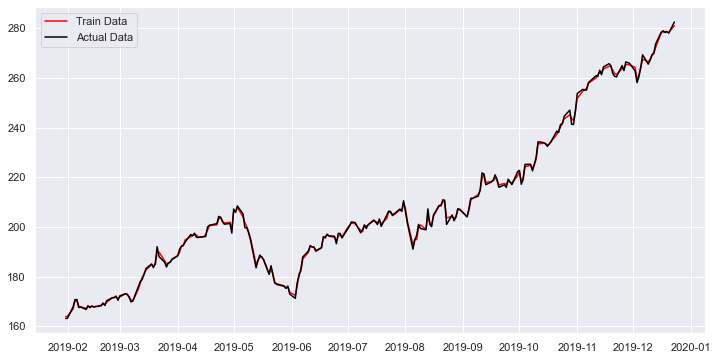

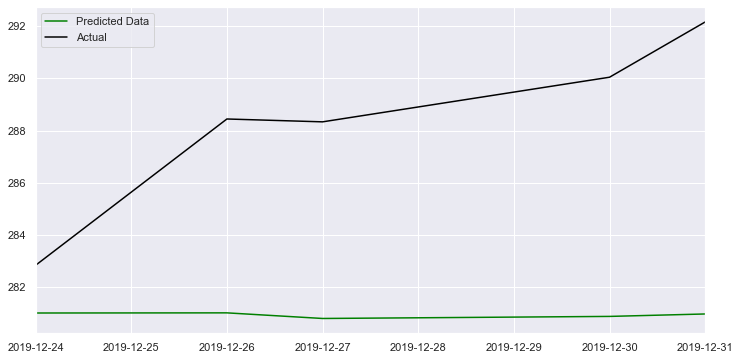

In [78]:
predict_using_random_forest(AAPL, AAPL_dates, num_forecast_days=5, estimators_user=100, max_depth=None)

## Using SVM (Regression) for Apple Stock

I next tried to leverage SVR (A component of SVM) to predict Apple's stock price. I chose to let GridSearch pick the best values and the predictions were much closer to the actual value two models from my testing.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using Grid Search Values C 1000 and gamma 1e-05 values
Predicted Values: [283.19151038 283.63517004 288.1878802  287.52463239 287.97661333]
------------------------------------------------------------------------------------------
Actual Values: [282.831299 288.44278  288.333313 290.044617 292.163818]
------------------------------------------------------------------------------------------
Model Score: 0.9954772382197665
------------------------------------------------------------------------------------------
Model R2 Score: 0.015329526748475986
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 9.429404376749398
------------------------------------------------------------------------------------------
RMSE: 3.0707335242168763


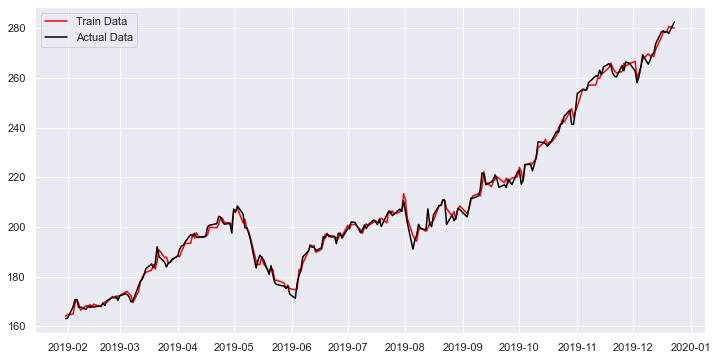

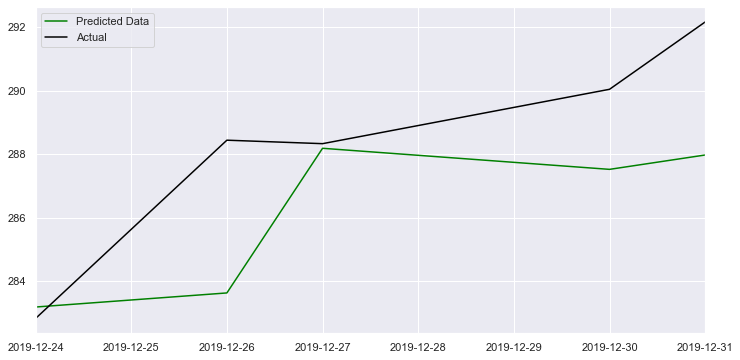

In [79]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='rbf')

## Predicting Amazon Stock Prices

## Correlation Matrix based for Amazon

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

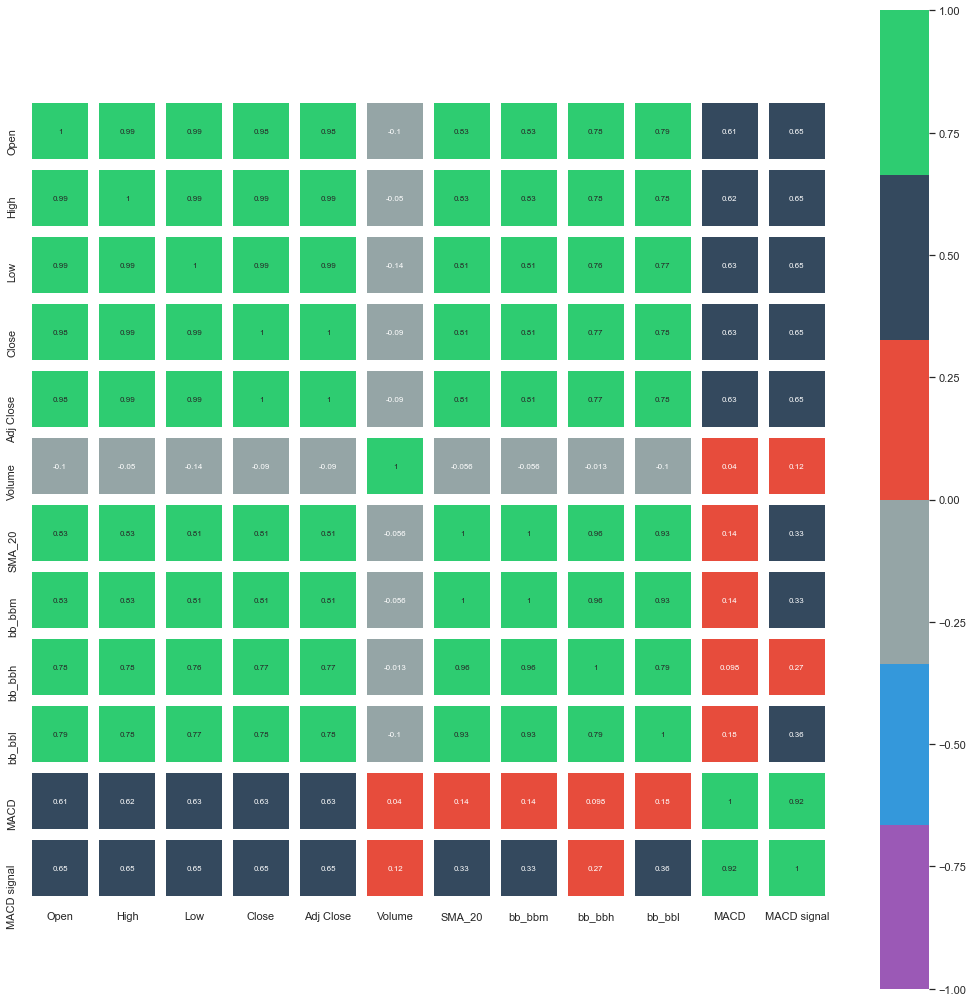

In [80]:
corr_plot(AMZN)

## Using Random Forests for Amazon Stock

In this test, I used Random Forests to forest prices for Amazon. Random Forests captured the trend prettu well up until the final days. It miscalculated on a few days, but overall it was ok.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [1781.95650258 1794.96479508 1879.14440535 1869.42250846 1834.47778828]
------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
------------------------------------------------------------------------------------------
Train Model Score: 1.0
------------------------------------------------------------------------------------------
Test Model Score: 1.0
------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9943257943125917
------------------------------------------------------------------------------------------
Test Model R2 Score: -0.4579195349025389
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 1254.6803870168376
------

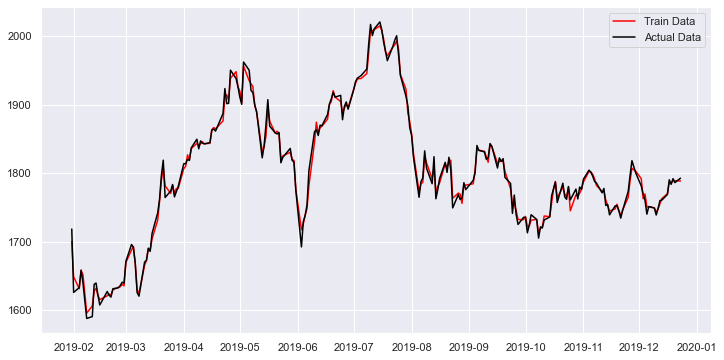

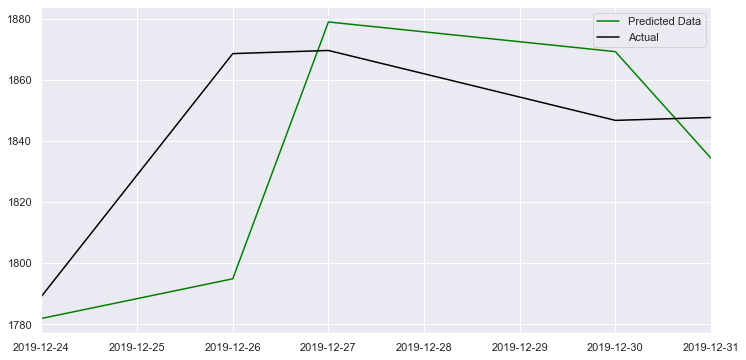

In [81]:
predict_using_random_forest(AMZN, AMZN_dates, num_forecast_days=5, estimators_user=100, max_depth=None)

## Using SVM (Regression) for Amazon 

I next tried to leverage SVR (A component of SVM) to predict Amazon's stock price. SVR did better at predicting the general trends (increase/decrease) vs Random Forests. The model score was 0.96, but looking at the graphs, the trends were generally the same vs Random Forests.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 1e-05 values
Predicted Values: [1781.96883403 1784.29741922 1848.5741245  1839.77444504 1812.48734658]
------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
------------------------------------------------------------------------------------------
Model Score: 0.9683123540022425
------------------------------------------------------------------------------------------
Model R2 Score: -1.0774041145864826
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 1787.8066217515775
------------------------------------------------------------------------------------------
RMSE: 42.282462342578604


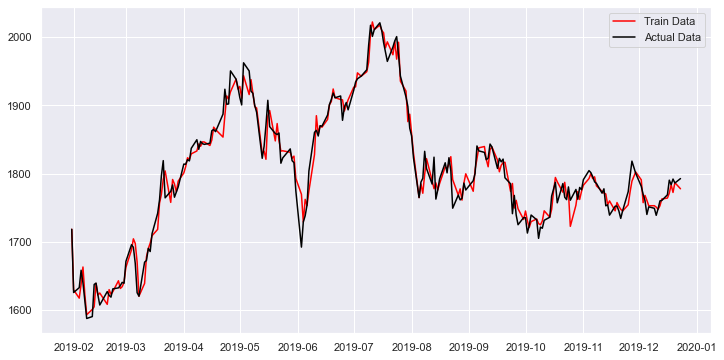

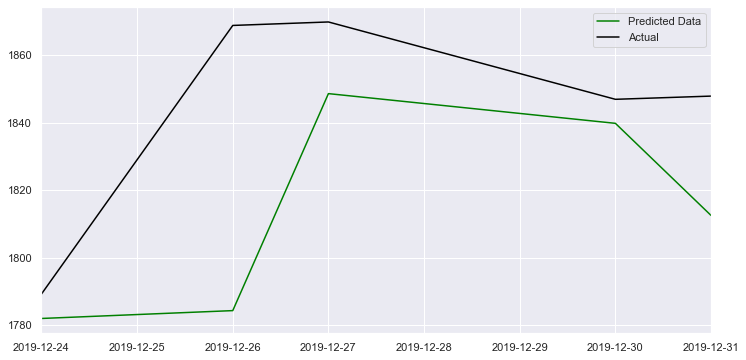

In [82]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=1000, G_user=.00001)


## Predicting Google Stock Prices



## Correlation Matrix based for Google

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

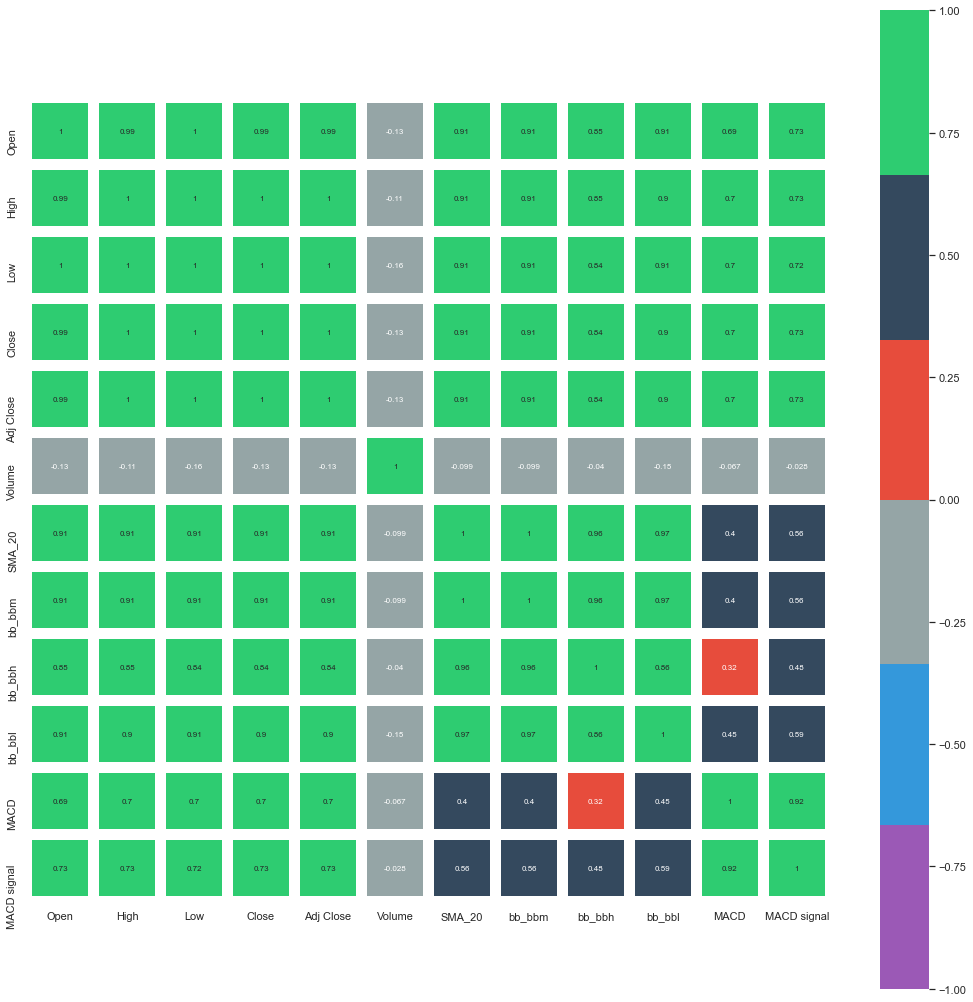

In [83]:
corr_plot(GOOG)

## Using Random Forests for Google

Random forests for Google Stock seems to handle the predictions with a fairly stable price change. In testing, it appears that the price changes impacted how much Random Forests would shift the price up/down.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [1349.12071854 1349.16971099 1349.72705557 1349.25568925 1342.53974768]
------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
------------------------------------------------------------------------------------------
Train Model Score: 1.0
------------------------------------------------------------------------------------------
Test Model Score: 1.0
------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9958471775679957
------------------------------------------------------------------------------------------
Test Model R2 Score: 0.14438918396249545
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 72.84151262875687
-------

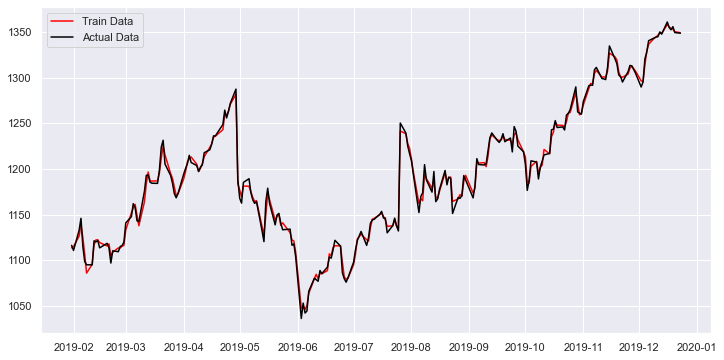

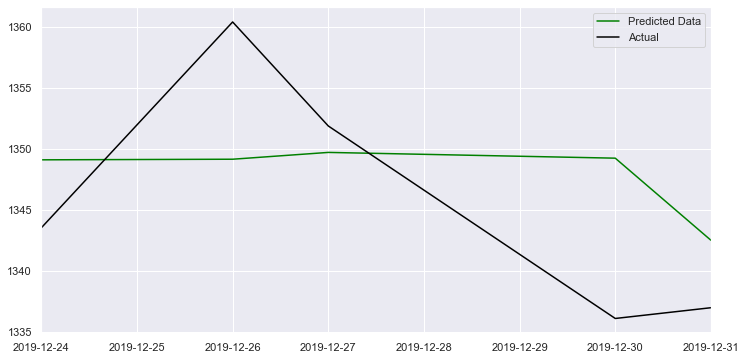

In [84]:
predict_using_random_forest(GOOG, GOOG_dates, num_forecast_days=5, estimators_user=1000, max_depth=None)

## Using SVM (Regression) for Google

SVM appears to capture the general trend (up/down) after day 1 fairly well. After that is fails or predict the price in the opposite direction as it does in day 1.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 0.0009 values
Predicted Values: [1338.98224563 1327.50971343 1309.32831451 1300.24275468 1243.46359312]
------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
------------------------------------------------------------------------------------------
Model Score: 0.9937712999009238
------------------------------------------------------------------------------------------
Model R2 Score: -29.435915102093272
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 2591.129112350679
------------------------------------------------------------------------------------------
RMSE: 50.903134602406155


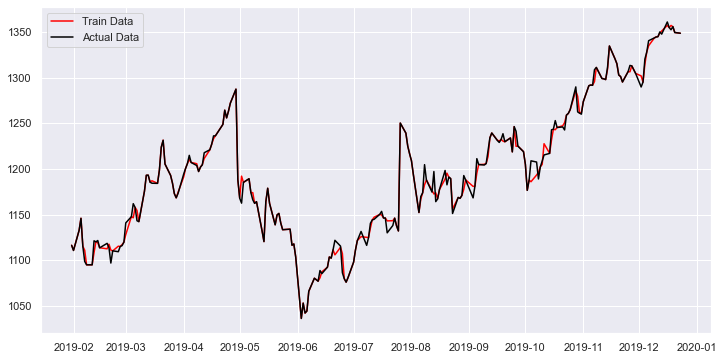

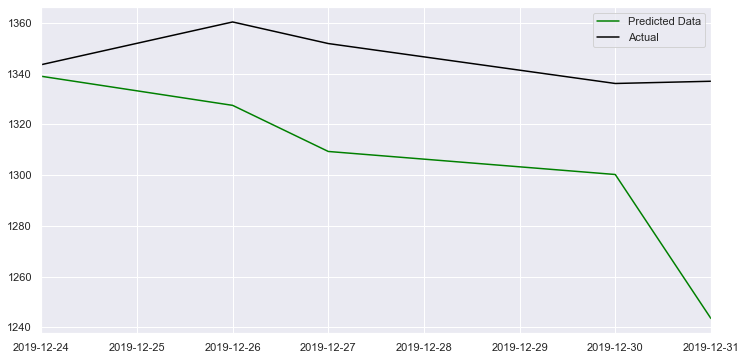

In [85]:
predict_multiple_variables(GOOG, GOOG_dates , num_forecast_days=5, C_user=1000, G_user=.0009,model =  'rbf')


## Predicting the S&P Index



## Predicting the S&P Index with Random Forests

Random Forests does overall better job of predicting the value long term, but SVR appears to capture the general trend much better.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [3220.25898778 3218.17285784 3216.67173626 3219.86094384 3216.23705416]
------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
------------------------------------------------------------------------------------------
Train Model Score: 1.0
------------------------------------------------------------------------------------------
Test Model Score: 1.0
------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9963810910837241
------------------------------------------------------------------------------------------
Test Model R2 Score: -2.963134855757955
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 248.18445887568163
-------

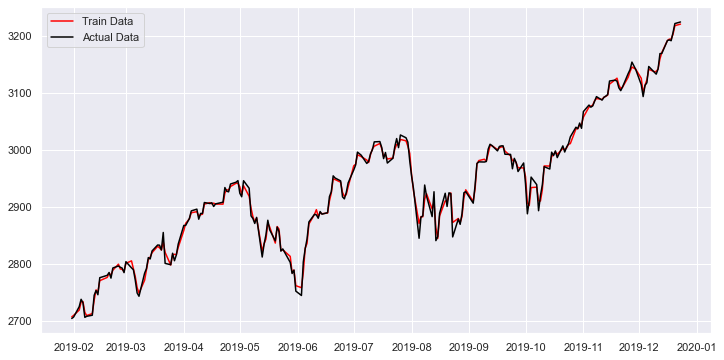

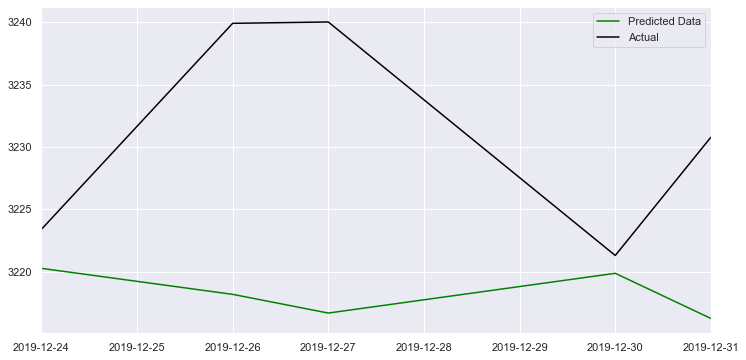

In [86]:
predict_using_random_forest(_GSPC, _GSPC_dates, num_forecast_days=5, estimators_user=1000, max_depth=None)

## Predicting the S&P Index with SVM (SVR)

SVR appears to capture the general trend of the S&P much better than Random Forests. The price gap, however, appears to diverge significantly after day 3 vs Random Forests. So while SVR captures the trend better, Random Forests stays closer to the actual prices during predictions.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 9e-05 values
Predicted Values: [3226.08732171 3226.15327491 3215.55131216 3218.79033614 3220.12542198]
------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
------------------------------------------------------------------------------------------
Model Score: 0.9861616259107151
------------------------------------------------------------------------------------------
Model R2 Score: -1.922434860331256
------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 183.0124234498263
------------------------------------------------------------------------------------------
RMSE: 13.528208434594223


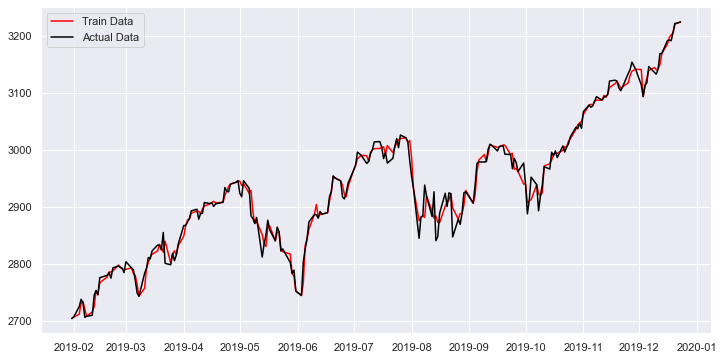

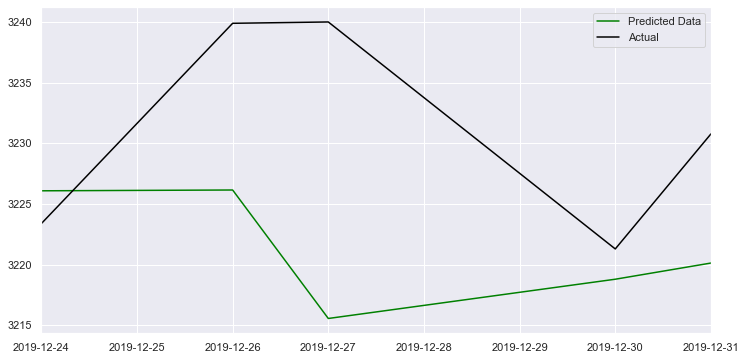

In [87]:
predict_multiple_variables(_GSPC, _GSPC_dates, num_forecast_days=5, C_user=1000, G_user=.00009,model =  'rbf')

# Prediction using Recurrent Neural Network (RNN) and Long Short Term Memory (LSTM)

## Prediction using Tensor Flow

The following is an attemp to use TensorFlow for predicting a "price" on a single data using sone number of "lookback" days.

The model chosen is a Long Short Term Memory, which is a subset of Recurrent Neural Network. RNNs provode good affinity where "memory" is needed and there is influence of prior observations on the current observation. Stock market prices are clearly impacted by their history and recent history is most influential. An LSTM vs RNN will raised the influence of the nearer periods vs. the longer term periods for affecting the model weights.


This is far from complete and signifiant portions were taken from [How to Predict Stock Prices in Python using TensorFlow 2 and Keras](https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras)


### Issues
- The first issue in the data wrangling is ensuring that we are NOT using a period of time in the training that is part of the prediction window. In the code below, the "training" dataset is taken from `window-size` as the lookback period. The forward target prediction date is `predict-step` - where a `1` would be "predict the next day" and a `10` would be 'predict the prie 10 days out', through the modeling,training, testing as expected the further out, the worse the predction.

- Another issue is scaling the data. When using non-scaled data, the model performed worse - as expecte.
- 

### Setup functions

The first set of functions setup the needed re-usable parts.

In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

common_seed = 42
np.random.seed(common_seed)
tf.random.set_seed(common_seed)
random.seed(common_seed)


from dataclasses import dataclass
@dataclass
class TrainParameters():
    """this class setups up the parameters used throughout the train and prediction perids"""
    
    import os
    import time
    from typing import List
    from dataclasses import field
    
    import tensorflow as tf
    from tensorflow.keras.layers import LSTM
    from tensorflow.python.keras.engine import base_layer
    
    window_size : int = 50
    predict_step : int = 1
    test_split  : float = 0.20
    feature_columns : list = field(default_factory = lambda: ["adjclose", "volume", "open", "high", "low"])
    scale : bool = True
    shuffle : bool = True
    date_now : time = time.strftime("%Y-%m-%d")
    model_layers: int = 3
    model_cell : base_layer = LSTM
    lstm_neurons : int = 256
    dropout : float = 0.40
    
    ### training parameters
    # mean absolute error loss
    # LOSS = "mae"
    # huber loss
    loss : str = "huber_loss"
    optimizer: str = "adam"
    batch_size : int = 64
    epochs : int = 400

    ticker : str = 'MSFT'

    #both must be dynamoic as they are resolved late.
    @property
    def ticker_file(self):
        import os
        return os.path.join("data", f"{self.ticker}_{self.date_now}.csv")
        
    @property
    def model_name(self):
        # model name to save, making it as unique as possible based on parameters
        return f"{self.date_now}_{self.ticker}-{self.loss}-{self.optimizer}-{self.model_cell.__name__}-seq-{self.window_size}-step-{self.predict_step}-layers-{self.model_layers}-units-{self.lstm_neurons}"


def load_data(p : TrainParameters):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        window_size (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        predict_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    from yahoo_fin import stock_info as si
    from collections import deque
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(p.ticker, str):
        # load it from yahoo_fin library
        print('calling yahoo fin...')
        df = si.get_data(p.ticker)
    elif isinstance(p.ticker, pd.DataFrame):
        # already loaded, use it directly
        print('data loaded as a Pandas DataFrame')
        df = p.ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in p.feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    if p.scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in p.feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `predict_step`
    # this makes 'future' the price FROM the future for that set of features.
    # eg. feature date 2/15/20 -- price date is from 2/16/20
    df['future'] = df['adjclose'].shift(-p.predict_step)

    # last `predict_step` columns contains NaN in FUTURE column
    # get them before droping NaNs
    last_sequence = np.array(df[p.feature_columns].tail(p.predict_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=p.window_size)

    for entry, target in zip(df[p.feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == p.window_size:
            #now we can add the future price as we are at the end of the sequence
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `predict_step` sequence
    # for instance, if window_size=50 and predict_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # reshape X to fit the neural network
    print(f'X shape: {X.shape}')
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    print(f'X shape after: {X.shape}')
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=p.test_split, shuffle=p.shuffle)
    # return the result
    return result


def create_model(p : TrainParameters):
    """this creates the TF model as a RNN/LSTM"""
    """The input layer neurons is matched to the lookback period"""
    """the output layer is a single nueron - for the prediction value"""
    """the input data is 3D with each data point a 50x5 item - where """
    """the 5 represents the close, high, open, low, volume"""
    """an option would be to flatten even further but that was not done."""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout    

    model = Sequential()
    for i in range(p.model_layers):
        if i == 0:
            # first layer
            model.add(p.model_cell(p.lstm_neurons, return_sequences = True, input_shape = (None, p.window_size)))
        elif i == p.model_layers - 1:
            # last layer
            model.add(p.model_cell(p.lstm_neurons, return_sequences= False))
        else:
            # hidden layers
            model.add(p.model_cell(p.lstm_neurons, return_sequences = True))
        # add dropout after each layer
        model.add(Dropout(p.dropout))
        
    #final layer is 1 output given "prediction"
    model.add(Dense(1, activation="linear"))
    model.compile(loss = p.loss, metrics=["mean_absolute_error"], optimizer = p.optimizer)
    return model


def plot_graph2(model, X_actual, y_actual, p : TrainParameters, back_range = 200, figure_size = (15,15)):
    """unfortunately this is a poorly working not used funciton"""
    import matplotlib.pyplot as plt
    plt.figure(figsize = figure_size)
    
    y_pred = model.predict(X_actual)
    if p.scale:
        y_actual = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_actual, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))

    else:
        pass
        #y_test = np.squeeze(np.expand_dims(y_test, axis=0))
        #y_pred = np.squeeze(y_pred)
        
    plt.plot(y_actual[-back_range:], c='c') #b
    plt.plot(y_pred[-back_range:], c='k') #r
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    
def plot_graph(model, data, p : TrainParameters, back_range = 200, figure_size = (15,15)):
    """simply plots the lookback period of the prediction window"""
    """using actual and predicted"""
    import matplotlib.pyplot as plt
    plt.figure(figsize = figure_size)
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    if p.scale:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))

    else:
        pass
        #y_test = np.squeeze(np.expand_dims(y_test, axis=0))
        #y_pred = np.squeeze(y_pred)
        
    plt.plot(y_test[-back_range:], c='c') #b
    plt.plot(y_pred[-back_range:], c='k') #r
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()


def get_accuracy(model, data, p: TrainParameters):
    from sklearn.metrics import accuracy_score
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    if p.scale:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))

    else:
        pass
        #y_test = np.squeeze(np.expand_dims(y_test, axis=0))
        #y_pred = np.squeeze(y_pred)
    
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-p.predict_step], y_pred[p.predict_step:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-p.predict_step], y_test[p.predict_step:]))
    return accuracy_score(y_test, y_pred)


def predict(model, data, p: TrainParameters):
    """uses the trained model and predicts"""
    """adjusts data if scaled as needed"""
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:p.window_size]

    # reshape the last sequence  - flip the x,y
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    if p.scale:
    # get the price (by inverting the scaling)
        # retrieve the column scalers
        column_scaler = data["column_scaler"]
        predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
        return predicted_price

    else:
        predicted_price = prediction[0][0]
        return predicted_price
    


In [89]:
# TODO: work plotting as it's using the X_train/test data which isn't the Last N items.

ticker_or_file = 'MSFT'
# comment these next 2 lines to read from internet.
#file_from_csv = pd.read_csv('data/MSFT_2020-05-04.csv')
#ticker_or_file = file_from_csv

run_parms = TrainParameters(
                ticker = ticker_or_file,
                epochs=300, 
                predict_step=1, # predict 1 day in the future.
                window_size=50,
                scale = True)

data = load_data(run_parms)

if not os.path.isdir("data"):
    os.mkdir("data")
    
#data['df'].to_csv(run_parms.ticker_file)

model = create_model(run_parms)

calling yahoo fin...
X shape: (8560, 50, 5)
X shape after: (8560, 5, 50)


In [82]:
history = model.fit(data["X_train"], data["y_train"],
                    batch_size = run_parms.batch_size,
                    epochs = run_parms.epochs,
                    validation_data = (data["X_test"], data["y_test"]),
                    #callbacks=[checkpointer, tensorboard],
                    verbose=0)

In [83]:
# df is a copy of the data frame - raw data 
# column_scaler are the instances used to scale each column.
# last_sequence are the prediction window
# X_train/test and Y_train/test are the respective splitsd
[k for k in data]

['df',
 'column_scaler',
 'last_sequence',
 'X_train',
 'X_test',
 'y_train',
 'y_test']

Mean Absolute Error: 0.7601045
Future price after 1 days is $ 184.03
Accuracy Score: 0.9807130333138515


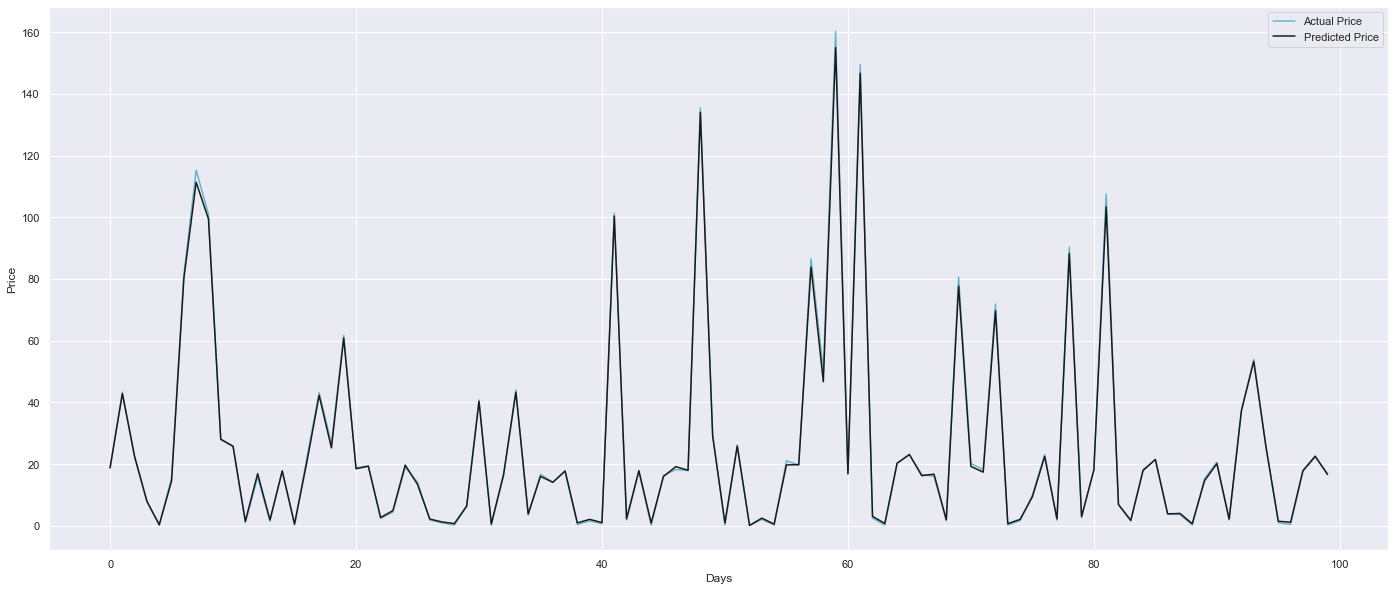

In [84]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)


if run_parms.scale:
# calculate the mean absolute error (inverse scaling)
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
else:
    mean_absolute_error = mae.reshape(1, -1)[0][0]

print("Mean Absolute Error:", mean_absolute_error)

# predict the future price
future_price = predict(model, data, run_parms)
print(f"Future price after {run_parms.predict_step} days is $ {future_price:.2f}")
#print(f"real price on date {data['df'][-a.predict_step]}")
print("Accuracy Score:", get_accuracy(model, data, run_parms))
plot_graph(model, data, run_parms, back_range = 100, figure_size=(24,10))